# Import

In [2]:
## Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp

from scipy.stats import chi2_contingency
from os.path import exists
from importlib import reload

import model
import wrangle
import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook


In [3]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/wrangle.py'>

In [4]:
train = wrangle.wrangle_oct(explore=True)

# Explore 

## Univariate

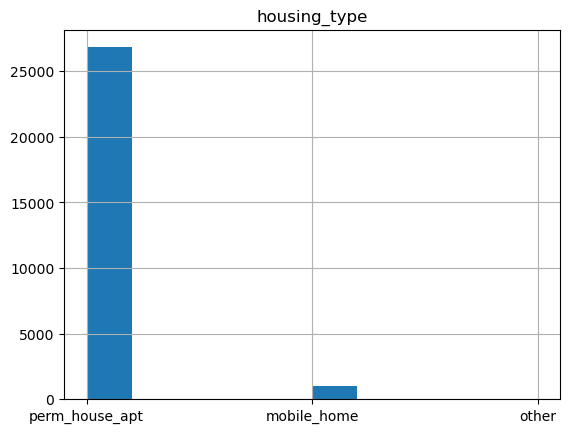

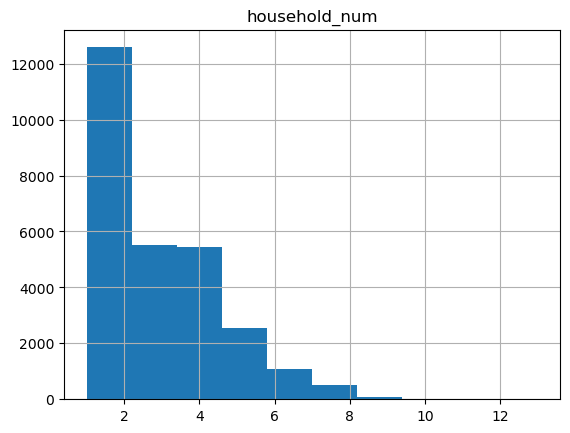

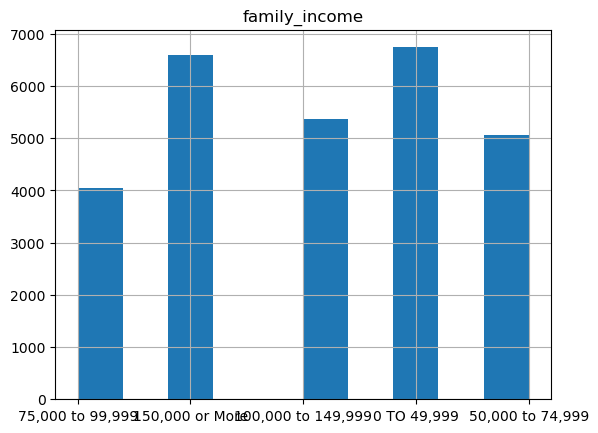

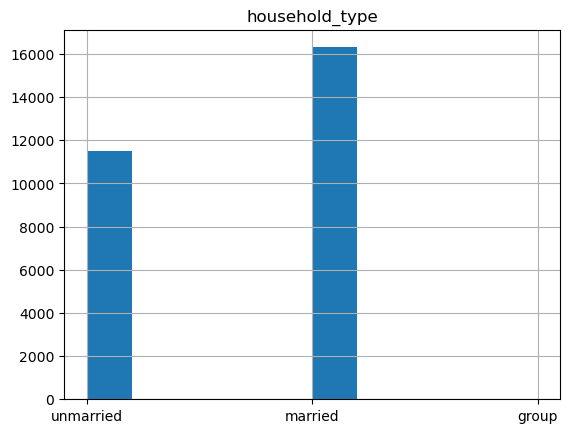

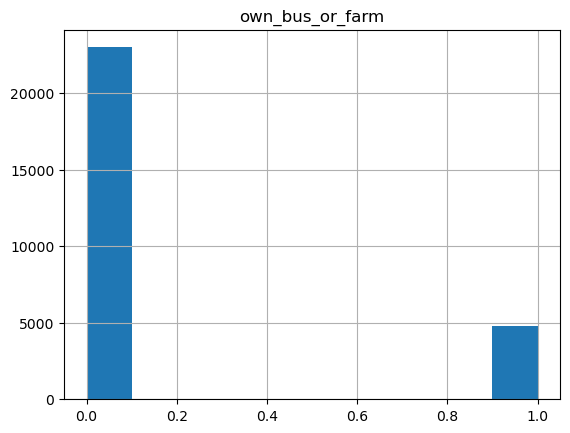

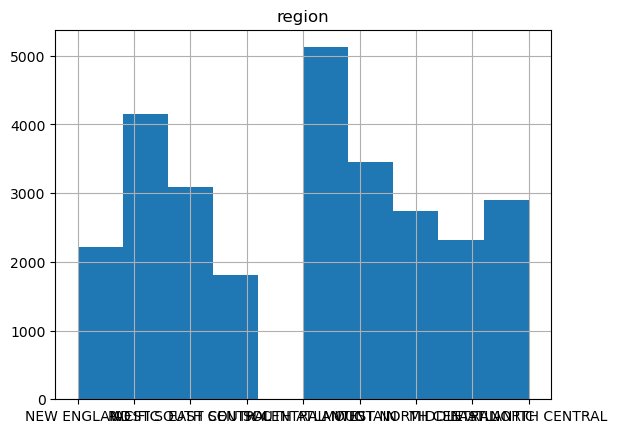

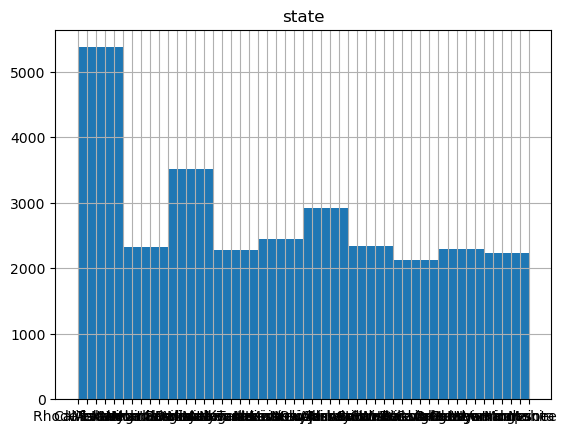

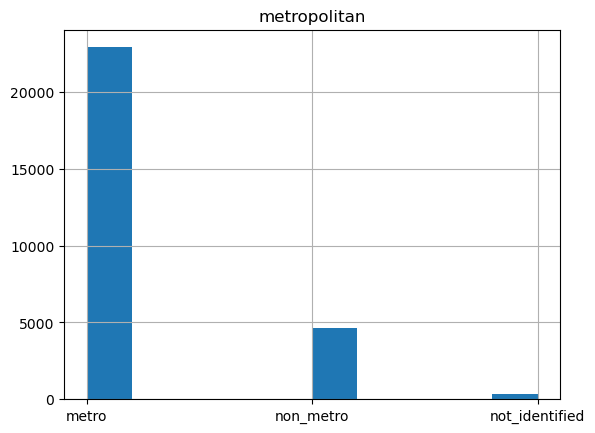

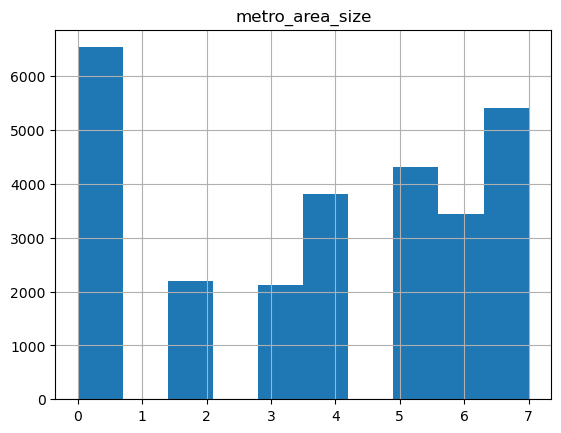

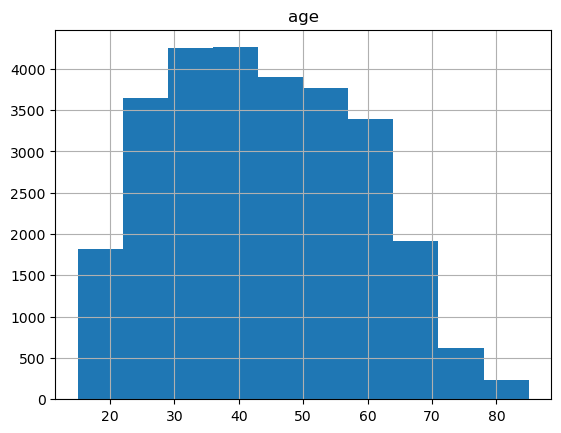

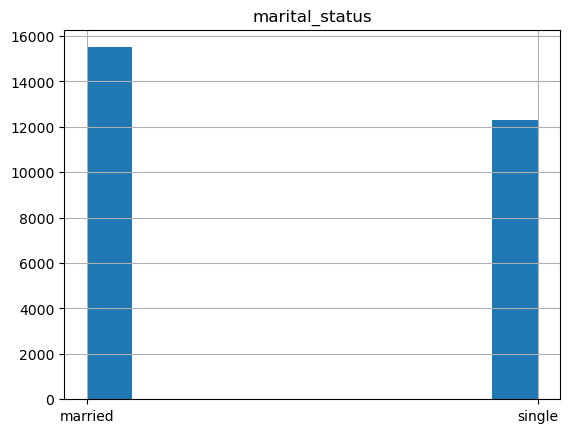

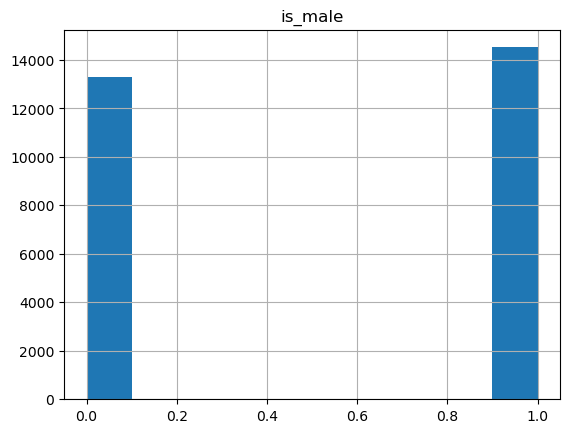

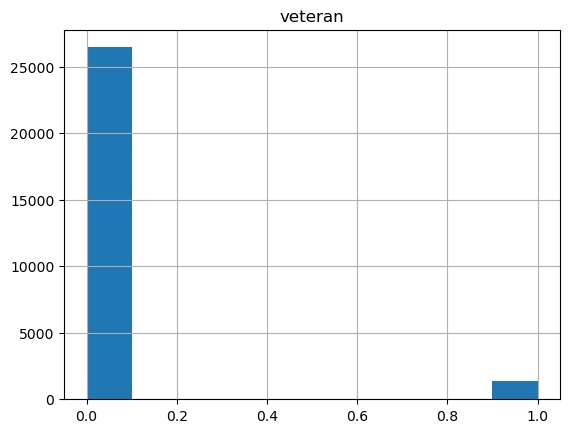

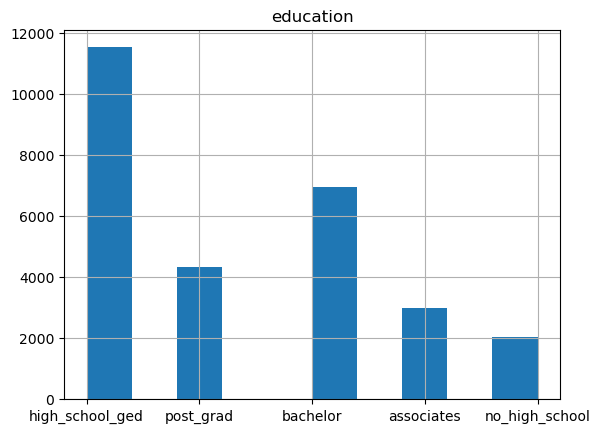

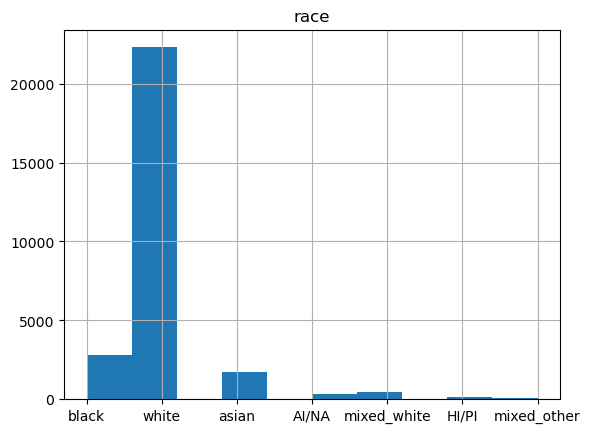

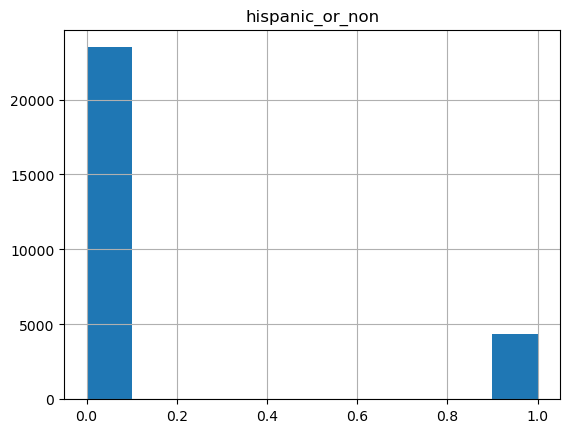

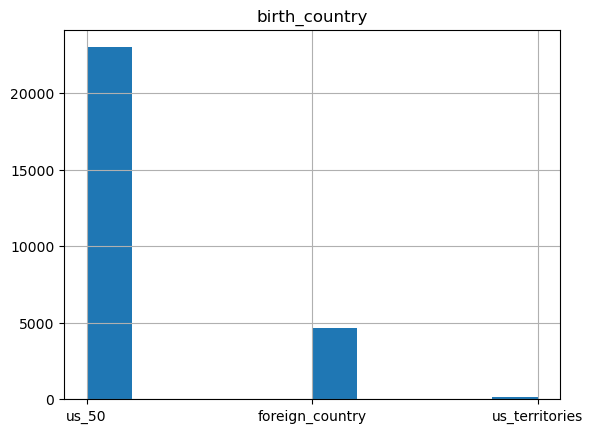

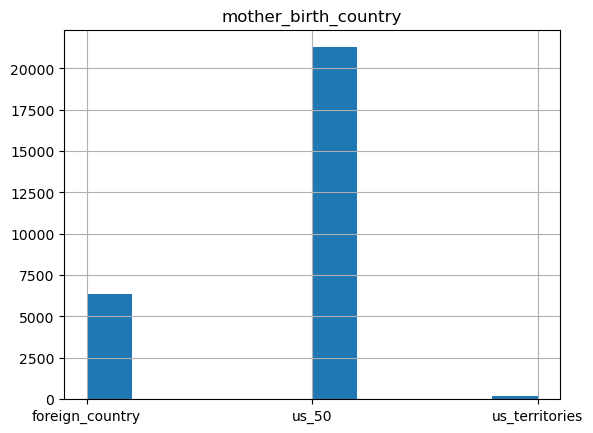

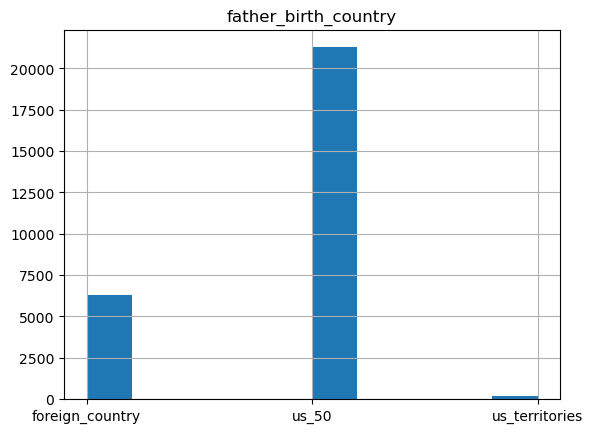

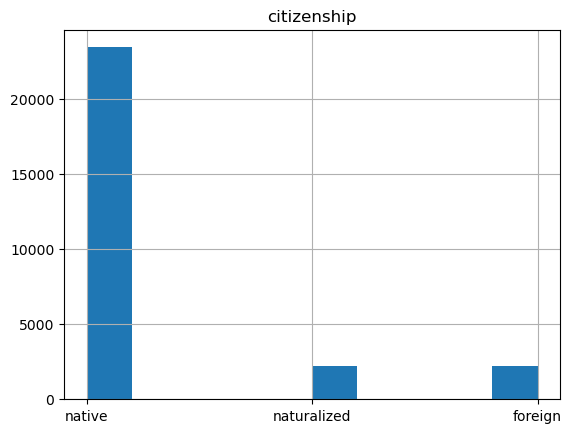

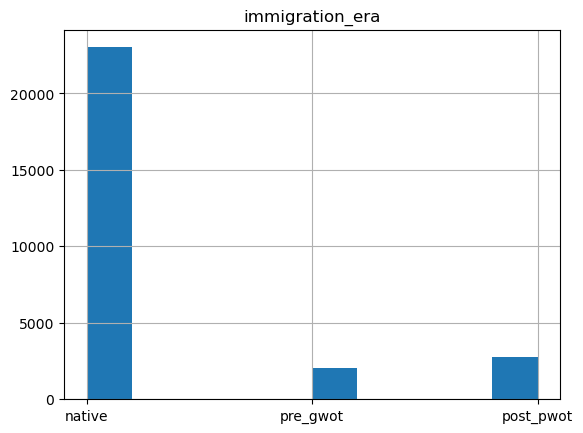

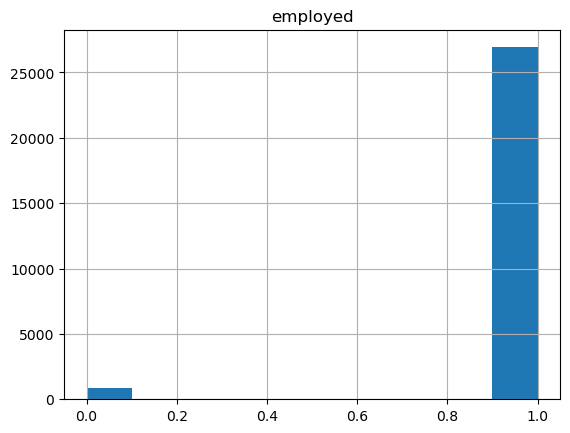

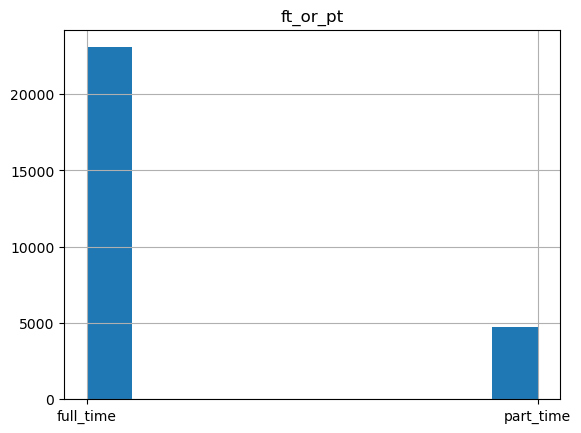

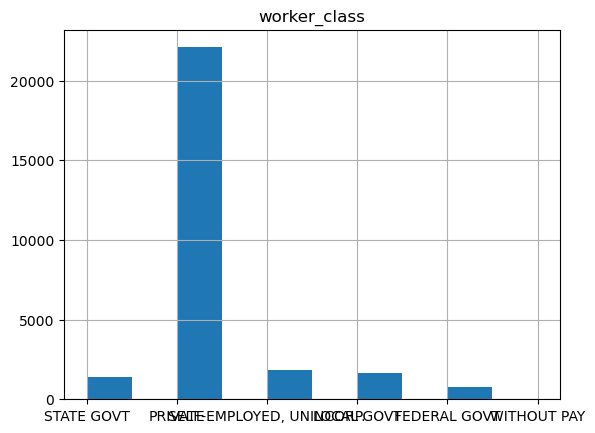

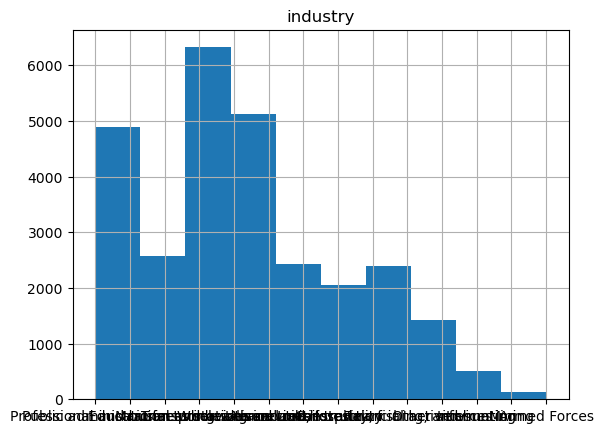

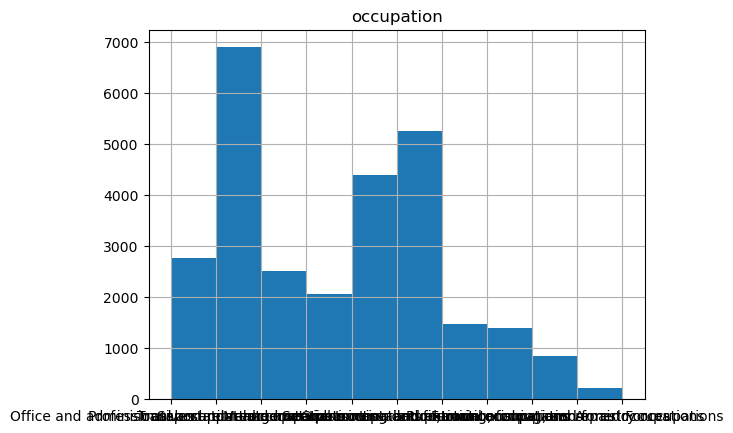

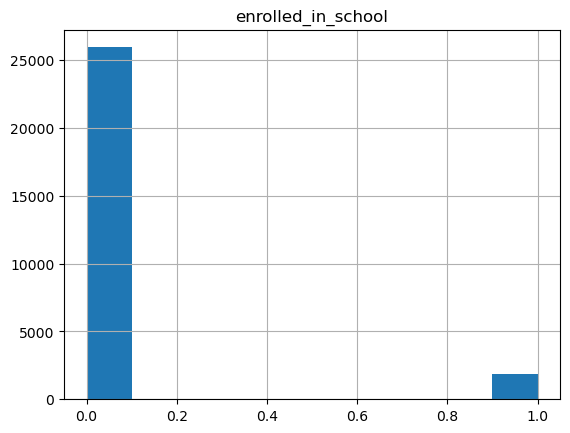

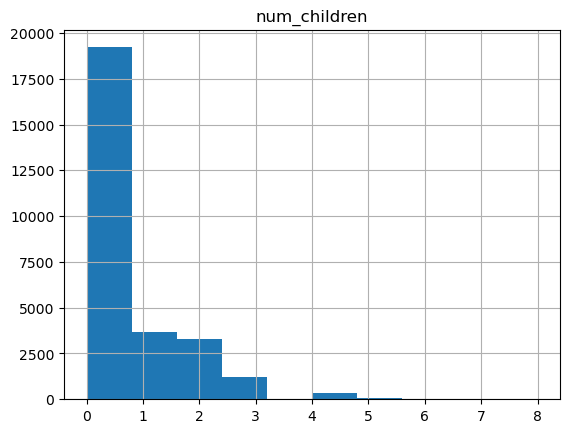

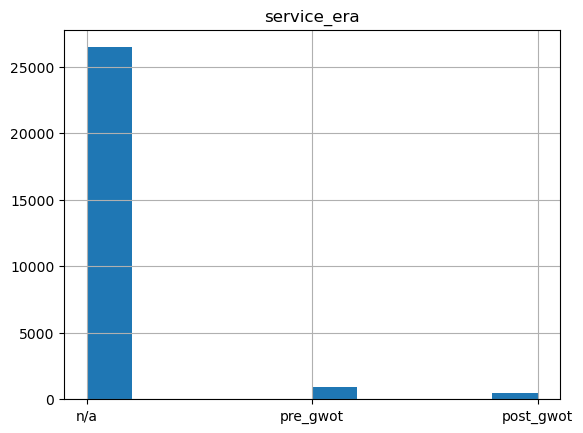

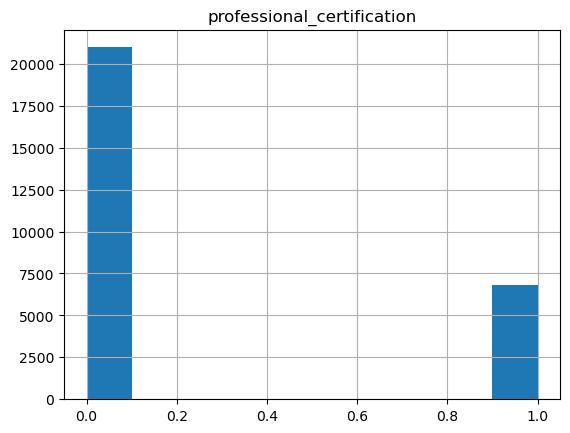

In [5]:
for col in train.columns:
    train[col].hist()
    plt.title(col)
    plt.show()

### Takeaways
* Skewed:
    - `family_income`, `household_num`, 'household_type`
* many responses from region 5 (south_atlantic)
* almost all respondents worked in last 12 months (train split)
* eliminate - `could_have_started_job`

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [6]:
# create column filter lists for plotting use

#fixing types on categorical columns
categorical_cols = ['housing_type','family_income','household_type',
                'region','state','metropolitan','metro_area_size',
                'marital_status','education','race','birth_country',
                'mother_birth_country','father_birth_country','citizenship',
                'industry','occupation']

binary_cols = ['own_bus_or_farm', 'is_male', 'veteran','hispanic_or_non', 
                'employed', 'enrolled_in_school','professional_certification']  

continuous_cols = ['age', 'household_num','num_children'] 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27818 entries, 3549 to 30192
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27818 non-null  object  
 1   household_num               27818 non-null  float64 
 2   family_income               27818 non-null  category
 3   household_type              27818 non-null  object  
 4   own_bus_or_farm             27818 non-null  int64   
 5   region                      27818 non-null  object  
 6   state                       27818 non-null  object  
 7   metropolitan                27818 non-null  object  
 8   metro_area_size             27818 non-null  float64 
 9   age                         27818 non-null  float64 
 10  marital_status              27818 non-null  object  
 11  is_male                     27818 non-null  int64   
 12  veteran                     27818 non-null  int64   
 13  education    

In [8]:
def plot_continuous_pairs (df, col_list):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df[col_list])
    
    #fills out the pairgrid with a regplot
    g.map(sns.regplot, line_kws={'color':'r'})
    return 

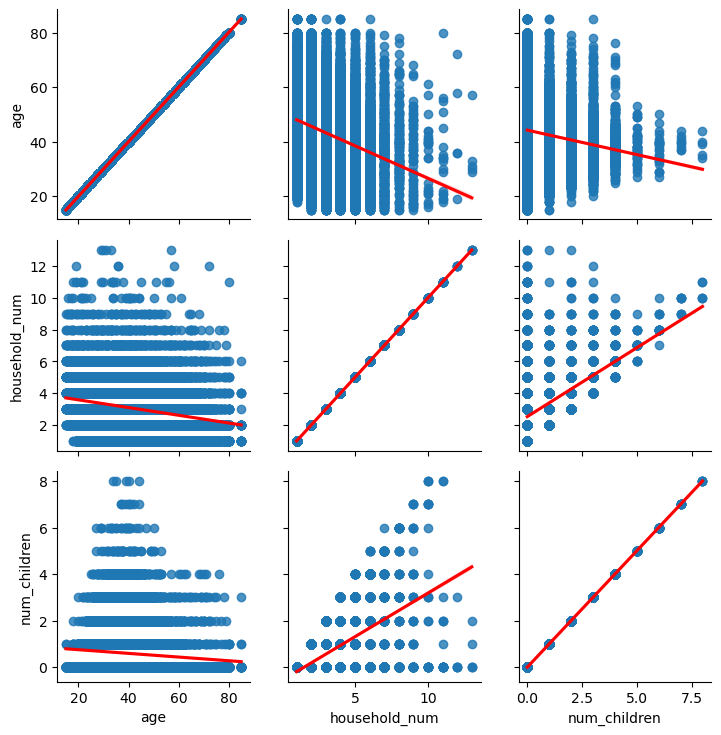

In [9]:
plot_continuous_pairs(train, continuous_cols)

### Takeaways
- Increases in age track with decreases in home size

## Bivariate - Categorical Plotting

In [10]:
unemployed = train[train.employed == 0]
employed = train[train.employed == 1]

In [11]:
unemployed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     15
Armed Forces                                     1
Construction                                    77
Educational and health services                152
Financial activities                            42
Information                                     19
Leisure and hospitality                        149
Manufacturing                                   75
Mining                                           3
Other services                                  34
Professional and business services             109
Public administration                           22
Transportation and utilities                    57
Wholesale and retail trade                     135
dtype: int64

In [12]:
employed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     534
Construction                                   1974
Educational and health services                6169
Financial activities                           1794
Information                                     481
Leisure and hospitality                        2287
Manufacturing                                  2490
Mining                                          132
Other services                                 1385
Professional and business services             3347
Public administration                          1405
Transportation and utilities                   1620
Wholesale and retail trade                     3310
dtype: int64

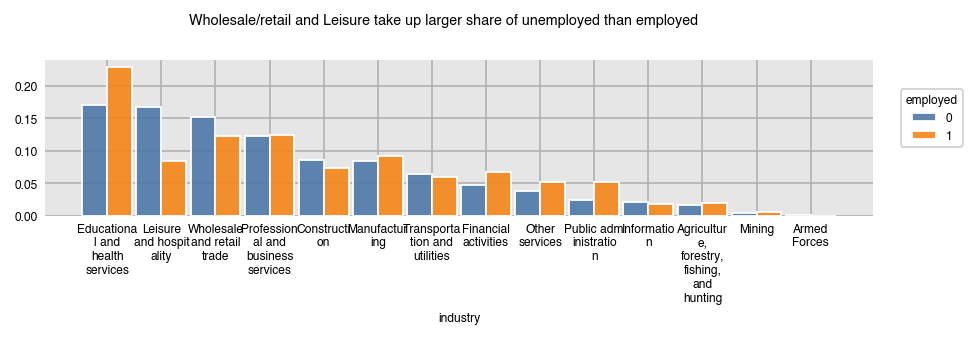

In [13]:
dxp.count('industry', data=train, split='employed', normalize='employed', title='Wholesale/retail and Leisure take up larger share of unemployed than employed')

### Takeaway
    Wholesale/retail and Leisure take up larger share of unemployed that employed

In [14]:
for col in train[categorical_cols]:
    dxp.count('industry', data=train, split='employed', normalize='employed')

### Takeaways
* Look for proportionality differences between employed vs not
* Columns for closer inspection
    - `occupation`, `industry`, `marital_status`, `race` 

### Bivariate - Binary Columns

<Figure size 2000x600 with 0 Axes>

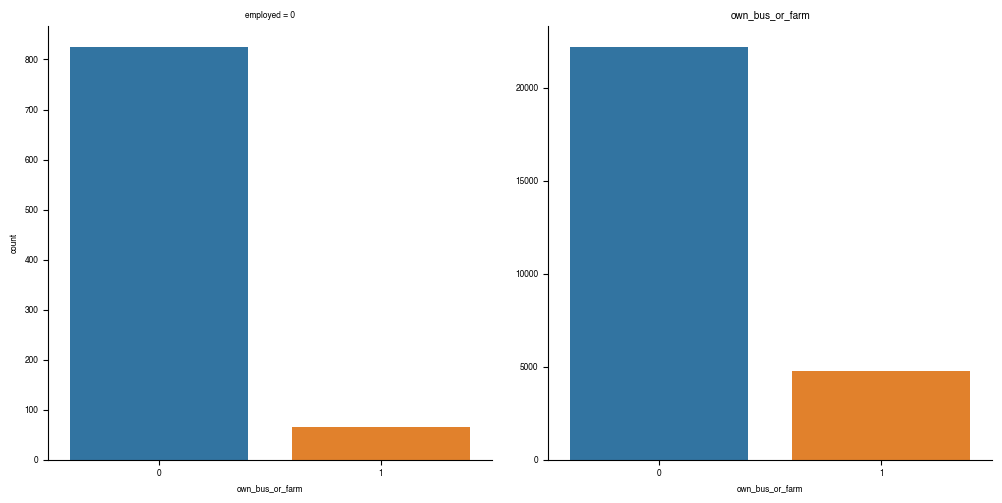

<Figure size 2000x600 with 0 Axes>

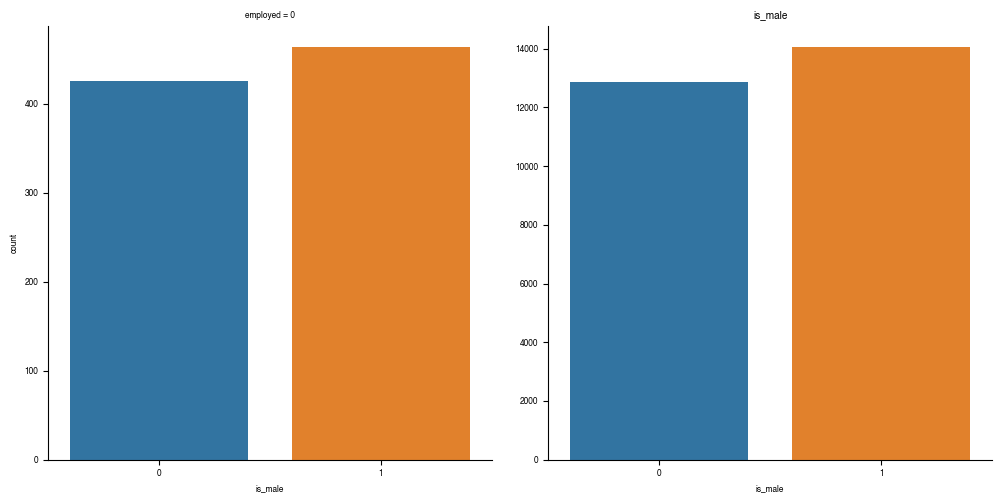

<Figure size 2000x600 with 0 Axes>

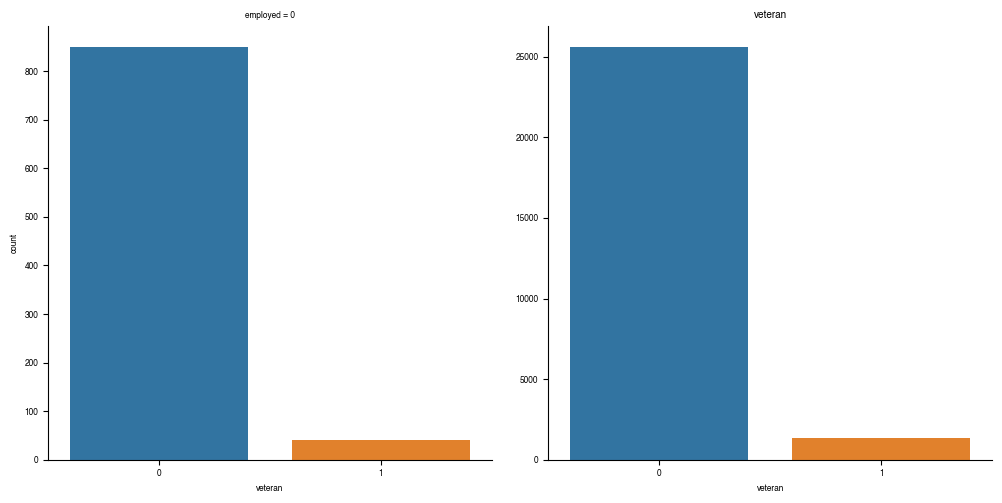

<Figure size 2000x600 with 0 Axes>

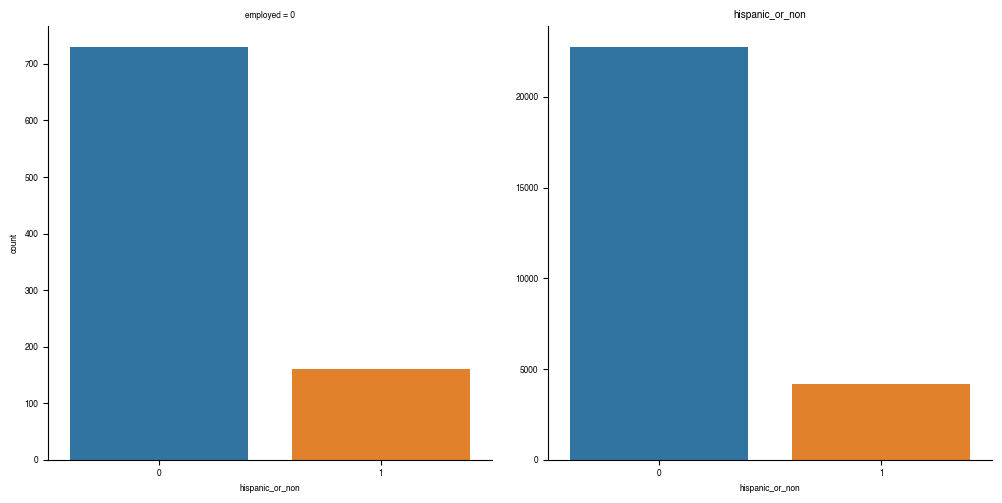

<Figure size 2000x600 with 0 Axes>

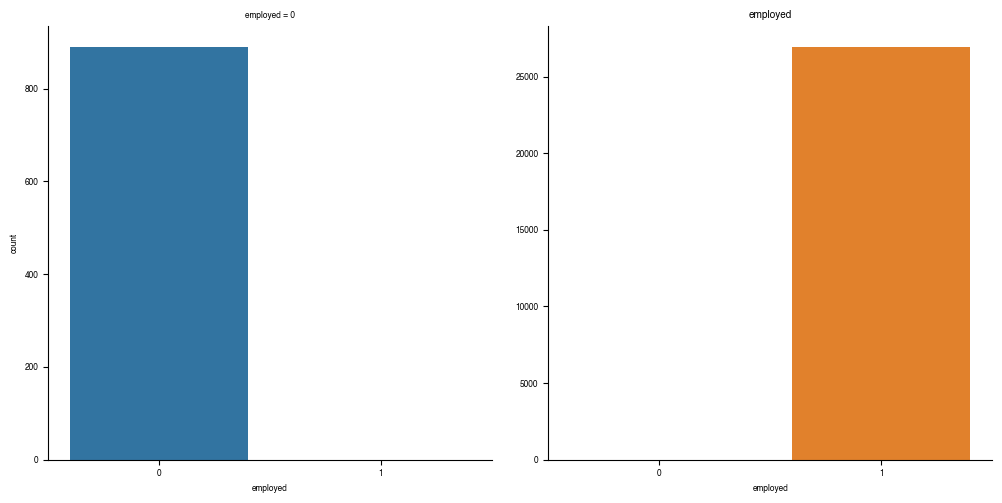

<Figure size 2000x600 with 0 Axes>

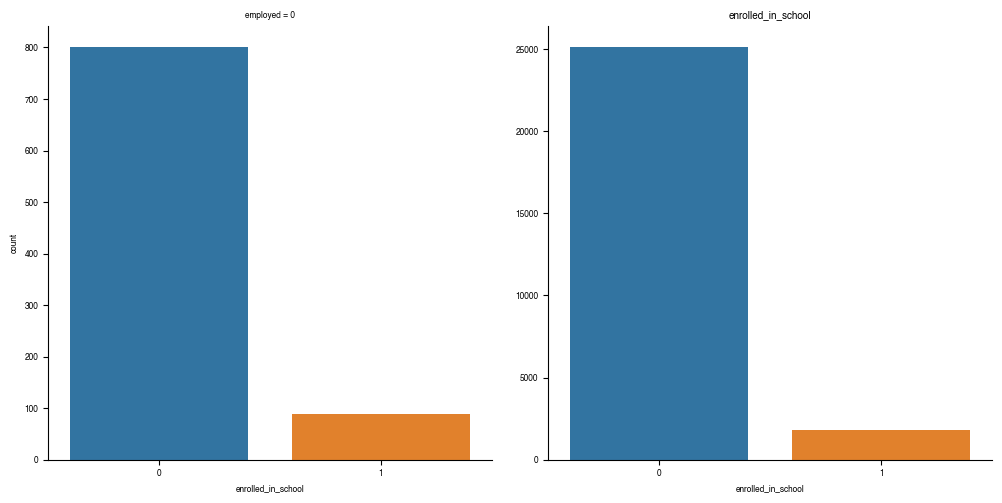

<Figure size 2000x600 with 0 Axes>

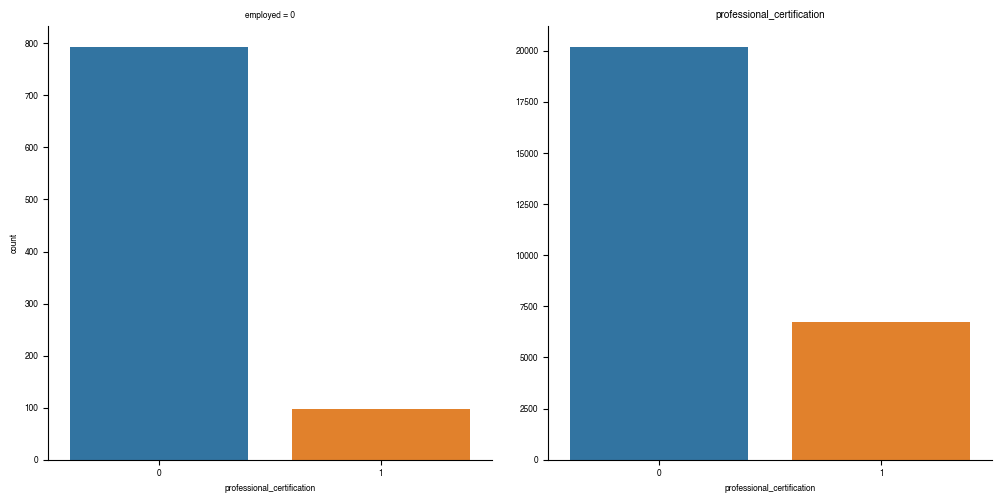

In [15]:
#loops throughs binary columns to creates a seaborn catplot for display

for col in train[binary_cols]:
    plt.figure(figsize=(20,6))
    sns.catplot(data=train, x=col, col='employed', kind='count', sharey=False, orient='y')
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(col)
    plt.show()

---
### Takeaways
* Gender reversal between employed and not,  change `is_male` --> `is_male` 
* Columns for closer inspection  
    * `professional_certification`  </b> 
---

## Specific Questions with plots and tests
* Goal:
    Create function for display of unemployment rate and population proportions of column values
* Flow:
    - Chi-2 --> t-test --> feature inclusion
* can bin interesting vs not intersting during feature selection for features the have categories that deviate 

## Spotlight Stats Function

In [16]:
# exported to model.py

def spotlight_stats(df, feature, title=None, phase=None, orientation=None):

    ''' 
    Purpose:
        To create visuals and print statistics for the feature of the data set
    ---
    Parameters:
        df: dataframe containing features
        feature: the feature (column) to be used for testing and visualization
        phase: the phase of the pipeline for which the output is needed
    ---
    Output:
        prop_df: dataframe that contains population proportions and unemployment rate
    ---
    '''

    multi_col = pd.MultiIndex.from_tuples([('population_proportions', 'employed'), 
                                    ('population_proportions', 'unemployed'),
                                    ('population_proportions', 'change')])
    
    # dataframe, 3 columns, 
    prop_df = pd.DataFrame(columns=multi_col)
    prop_df['unemployment_rate'] = round(1 - df.groupby(by=feature).employed.mean().sort_values(ascending=True), 2)

    # i want to show the proportion of the population that each categorical option is
    employed_pop_proportion = df[df.employed == 1][feature].value_counts(normalize=True) 

    # i want to show the proportion of the population that each categorical option is
    unemployed_pop_proportion = df[df.employed == 0][feature].value_counts(normalize=True) 
    
    #assign proper values to dframe
    prop_df[('population_proportions', 'employed')] = employed_pop_proportion
    prop_df[('population_proportions', 'unemployed')] = unemployed_pop_proportion
    prop_df[('population_proportions', 'change')] = employed_pop_proportion - unemployed_pop_proportion

    #chi2 test
    alpha = .05
    crosstab = pd.crosstab(df[feature], df["employed"])

    chi2, p, dof, expected = chi2_contingency(crosstab)

    #prints crosstab only if phase of project is explore. during model phase just plots graph
    if phase == 'explore':
        print('Crosstab\n')
        print(crosstab.values)
        print('---\nExpected\n')
        print(f'{expected.astype(int)}')
        print('---\n')

    print(f'chi^2: {chi2:.4f}')
    print(f'p: {p:.4f}')
    print(f'degrees of freedom: {dof}')

    if p < alpha :
        print('Reject null hypothesis')
    else: 
        print('Fail to reject null hypothesis')

    #plots the distributions of the feature in separate columns for employed vs unemployed
    plt.figure(figsize=(20,6))
    if orientation =='h':
        g = sns.catplot(data=df, y=feature, col='employed', kind='count', sharex=False)
    else:
        g = sns.catplot(data=df, x=feature, col='employed', kind='count', sharey=False)
    plt.suptitle(f'Spotlight: {title}', y=1.02)
    plt.show()

    return round(prop_df, 3)

## Spotlight - Industry 

* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between industry of typical employment and employment status   
>* ${H_a}$: There is a relationship between industry of typical employment and employment status  
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 140.6777
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

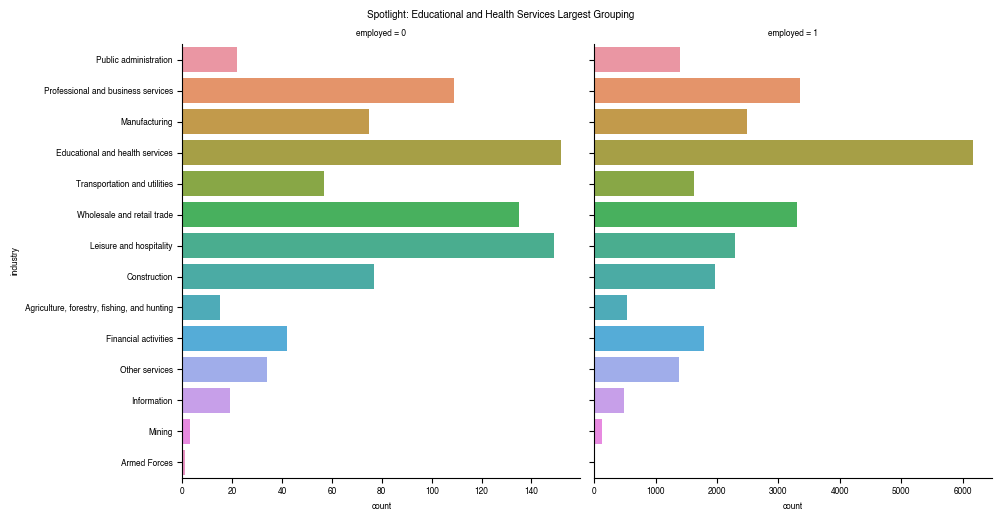

population_proportions             \
                                                          employed unemployed   
industry                                                                        
Armed Forces                                                   NaN      0.001   
Leisure and hospitality                                      0.085      0.167   
Wholesale and retail trade                                   0.123      0.152   
Information                                                  0.018      0.021   
Construction                                                 0.073      0.087   
Transportation and utilities                                 0.060      0.064   
Professional and business services                           0.124      0.122   
Manufacturing                                                0.092      0.084   
Agriculture, forestry, fishing, and hunting                  0.020      0.017   
Educational and health services                              0.229      0.171   
Other services                                               0.051      0.038   
Financial activities                                         0.067      0.047   
Mining                                                       0.005      0.003   
Public administration                                        0.052      0.025   

                                                   unemployment_rate  
                                            change                    
industry                                                              
Armed Forces                                   NaN              1.00  
Leisure and hospitality                     -0.082              0.06  
Wholesale and retail trade                  -0.029              0.04  
Information                                 -0.003              0.04  
Construction                                -0.013              0.04  
Transportation and utilities                -0.004              0.03  
Professional and business services           0.002              0.03  
Manufacturing                                0.008              0.03  
Agriculture, forestry, fishing, and hunting  0.003              0.03  
Educational and health services              0.058              0.02  
Other services                               0.013              0.02  
Financial activities                         0.019              0.02  
Mining                                       0.002              0.02  
Public administration                        0.027              0.02

In [17]:
spotlight_stats(train, 'industry','Educational and Health Services Largest Grouping', orientation='h')

#### Statistical Testing

In [18]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['industry'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  15  534]
 [   1    0]
 [  77 1974]
 [ 152 6169]
 [  42 1794]
 [  19  481]
 [ 149 2287]
 [  75 2490]
 [   3  132]
 [  34 1385]
 [ 109 3347]
 [  22 1405]
 [  57 1620]
 [ 135 3310]]
---
Expected

[[  17  531]
 [   0    0]
 [  65 1985]
 [ 202 6118]
 [  58 1777]
 [  15  484]
 [  77 2358]
 [  82 2482]
 [   4  130]
 [  45 1373]
 [ 110 3345]
 [  45 1381]
 [  53 1623]
 [ 110 3334]]
---

chi^2: 140.6777
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


### Count Plot for distribution

In [19]:
industry_counts = train.industry.value_counts()


In [20]:
#train[train.region == 'MOUNTAIN'].industry.value_counts().plot.barh() --> plot by region

<AxesSubplot:title={'center':'Educational and Health Services Largest Grouping'}>

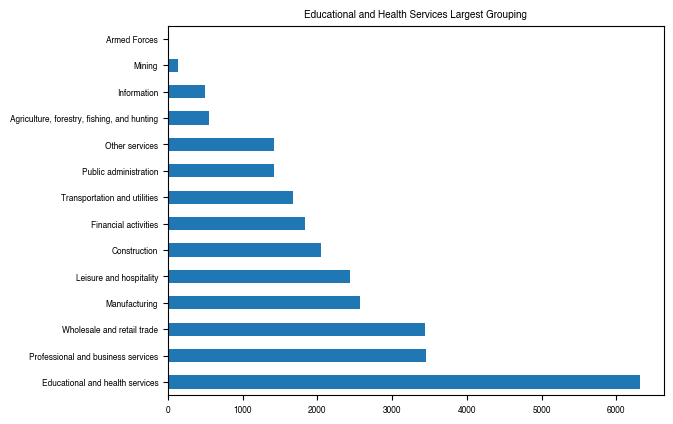

In [21]:
industry_counts.plot.barh(title='Educational and Health Services Largest Grouping')

In [22]:
# draw a grouped bar chart that shows industry proportion per region
df_bar = train.groupby(['region'])['industry'].value_counts(normalize=True).unstack()


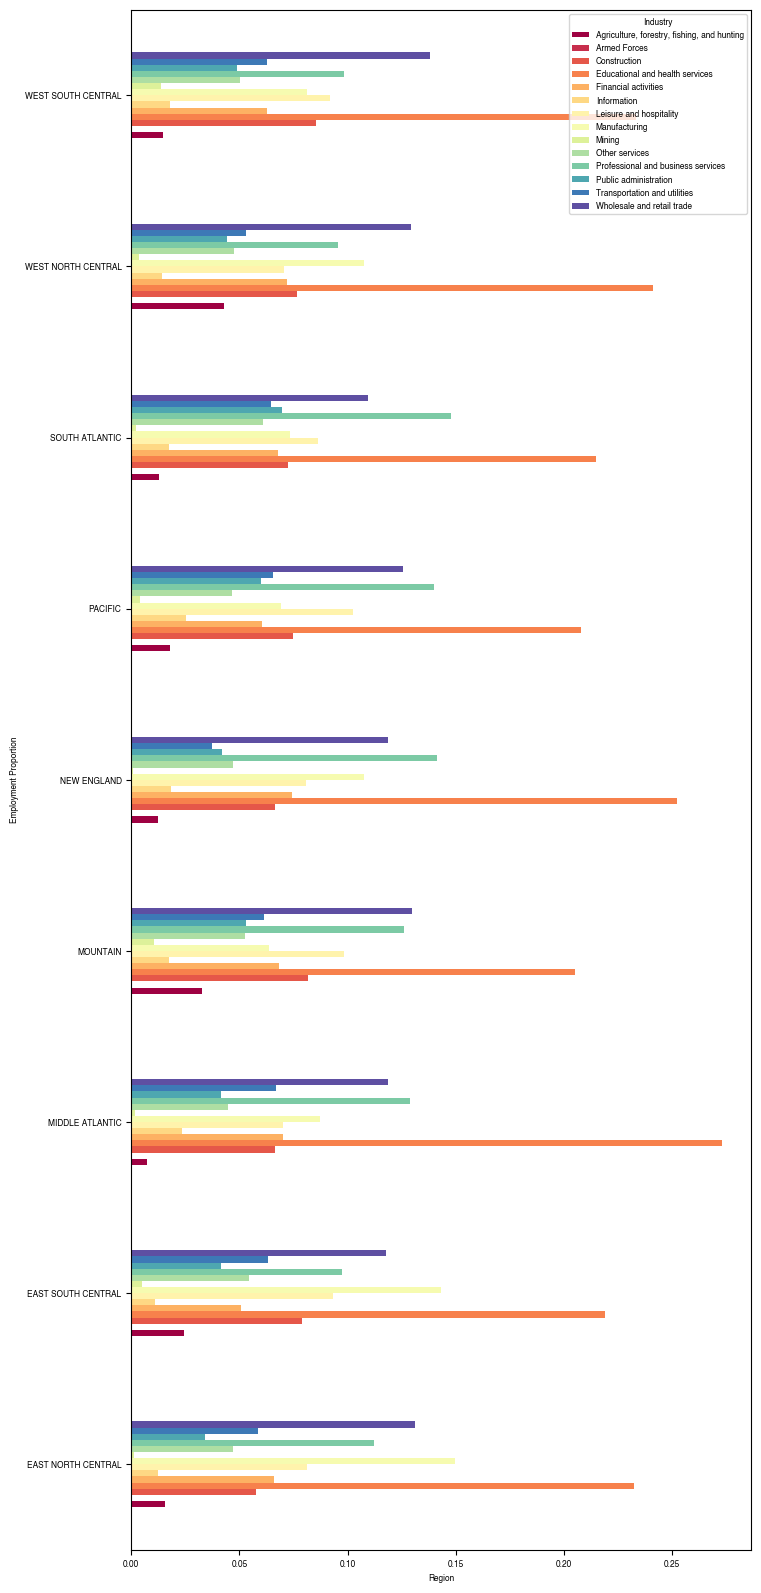

In [23]:

# Draw bar plot --> add 2nd legend
fig, ax = plt.subplots(figsize=(8,20))
df_bar.plot(kind='barh', ax=ax, colormap='Spectral')
plt.legend(title='Industry')
plt.ylabel('Employment Proportion')
plt.xlabel('Region')
plt.show()

In [24]:
# Chart Displaying industry proportions by region
train.groupby(['region'])['industry'].value_counts(normalize=True).unstack().T

region,EAST NORTH CENTRAL,EAST SOUTH CENTRAL,MIDDLE ATLANTIC,MOUNTAIN,NEW ENGLAND,PACIFIC,SOUTH ATLANTIC,WEST NORTH CENTRAL,WEST SOUTH CENTRAL
industry,,,,,,,,,
"Agriculture, forestry, fishing, and hunting",0.015512,0.024256,0.007321,0.032473,0.012217,0.017806,0.012881,0.042972,0.014858
Armed Forces,NaN,NaN,NaN,NaN,NaN,0.000241,NaN,NaN,NaN
Construction,0.057566,0.078831,0.066322,0.081763,0.066516,0.074832,0.072404,0.076839,0.085594
Educational and health services,0.232678,0.218853,0.273040,0.204987,0.252489,0.208133,0.214676,0.241442,0.233204
Financial activities,0.066184,0.050717,0.070198,0.068136,0.074208,0.060395,0.067721,0.072105,0.062661
Information,0.012410,0.011025,0.023256,0.017396,0.018552,0.025265,0.017564,0.014202,0.017765
Leisure and hospitality,0.081351,0.093164,0.070198,0.098579,0.080995,0.102743,0.086456,0.070648,0.092054
Manufacturing,0.149604,0.143330,0.087425,0.063497,0.107692,0.069057,0.073575,0.107793,0.081072
Mining,0.001379,0.004961,0.001723,0.010438,0.000905,0.003850,0.002147,0.003642,0.013889


#### Takeaways
* ag,for,fish, and hunt highest in east south central, mountain, and west north central.
* edu and health services min 20% in each region
* information (it) over 20% in only two regions (mid atl and pacific)
* manufacturing heavy in east north/south central


In [25]:
1-train.employed.mean()

0.03199367316126245

In [26]:
# unemployment rate for industries grouped by region
round(1-train.groupby(['region', 'industry'])['employed'].mean().unstack(), 3) 

industry,"Agriculture, forestry, fishing, and hunting",Armed Forces,Construction,Educational and health services,Financial activities,Information,Leisure and hospitality,Manufacturing,Mining,Other services,Professional and business services,Public administration,Transportation and utilities,Wholesale and retail trade
region,,,,,,,,,,,,,,
EAST NORTH CENTRAL,0.044,NaN,0.048,0.030,0.010,0.083,0.064,0.023,0.000,0.044,0.037,0.010,0.035,0.042
EAST SOUTH CENTRAL,0.000,NaN,0.028,0.020,0.033,0.000,0.047,0.031,0.111,0.000,0.040,0.027,0.026,0.070
MIDDLE ATLANTIC,0.000,NaN,0.045,0.028,0.025,0.019,0.067,0.030,0.000,0.000,0.037,0.000,0.039,0.033
MOUNTAIN,0.027,NaN,0.039,0.020,0.013,0.033,0.068,0.032,0.028,0.033,0.034,0.011,0.047,0.031
NEW ENGLAND,0.074,NaN,0.034,0.022,0.024,0.024,0.084,0.034,0.000,0.019,0.035,0.022,0.036,0.034
PACIFIC,0.041,1.0,0.042,0.032,0.040,0.057,0.054,0.028,0.000,0.031,0.031,0.012,0.048,0.038
SOUTH ATLANTIC,0.076,NaN,0.040,0.027,0.017,0.044,0.045,0.024,0.091,0.032,0.025,0.025,0.021,0.048
WEST NORTH CENTRAL,0.000,NaN,0.014,0.014,0.020,0.000,0.062,0.027,0.000,0.000,0.034,0.008,0.021,0.023
WEST SOUTH CENTRAL,0.000,NaN,0.042,0.018,0.031,0.036,0.077,0.044,0.000,0.026,0.023,0.013,0.031,0.040


In [27]:
for region in train.region.value_counts().index:
    print(region)

SOUTH ATLANTIC
PACIFIC
MOUNTAIN
WEST SOUTH CENTRAL
EAST NORTH CENTRAL
WEST NORTH CENTRAL
MIDDLE ATLANTIC
NEW ENGLAND
EAST SOUTH CENTRAL


In [28]:
round(1-train.groupby(['race', 'industry'])['employed'].mean().unstack(), 3)
# Takeaways
# * Construction with widely disproportionate unemployment rate
# * blacks with triple unemployment rate in professional and business services
# * mixed other with consistently high number across all industry



industry,"Agriculture, forestry, fishing, and hunting",Armed Forces,Construction,Educational and health services,Financial activities,Information,Leisure and hospitality,Manufacturing,Mining,Other services,Professional and business services,Public administration,Transportation and utilities,Wholesale and retail trade
race,,,,,,,,,,,,,,
AI/NA,0.000,NaN,0.042,0.015,0.000,0.000,0.073,0.067,0.000,0.056,0.045,0.000,0.071,0.240
HI/PI,NaN,NaN,0.000,0.000,0.133,0.000,0.062,0.000,0.000,0.000,0.000,0.000,0.000,0.000
asian,0.000,NaN,0.049,0.034,0.014,0.000,0.013,0.024,0.000,0.012,0.021,0.037,0.040,0.056
black,0.053,NaN,0.088,0.042,0.043,0.083,0.085,0.052,0.125,0.027,0.095,0.047,0.034,0.070
mixed_other,0.000,NaN,0.250,0.111,0.000,NaN,0.083,0.000,NaN,NaN,0.000,0.000,0.000,0.111
mixed_white,0.111,NaN,0.095,0.056,0.000,0.000,0.118,0.028,0.000,0.000,0.089,0.000,0.033,0.098
white,0.025,1.0,0.033,0.020,0.021,0.037,0.060,0.027,0.017,0.025,0.026,0.008,0.033,0.029


---
#### Takeaways - Industry
* Overall unemployment rate .031
* `Leisure and hospitality` with highest unemployment rate, highest jump in proportionality
* `Transportaion and utilities` with 2nd highest
* `Educational and Health Services` show greatest drop in portionality when moving from employed to unemployed 23% vs 17%
* Looking for sector/region combinations with more than double national employment rate
    * Ag in New England and South Atlantic
    * Leisure in mid atlantic, moutnain, new engalnd, 
    * mining in south atlantic
    * retail in east south central 
* information with highest unemployement rate (5.7%) in Pacific where it makes up highest percetange of workforce nationwide (2.5%)
* Construction with widely disproportionate unemployment rate
* blacks with triple unemployment rate in professional and business services
* mixed other with consistently high number across all industry
---

## Spotlight - Occupation



* **Question:** Which occupation shows the largest population proportion change between employed and unemployed?  
* **Answer:** Service occupations. These occupations also have the highest unemployment rate at 5%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between occupation and employment status  
>* ${H_a}$: There is a relationship between occupation and employment status  
* ${\alpha}$: .05
* Result: Reject the null hyptothesis. **Test Code Below**

In [116]:
train[train.industry != 'Armed Forces']

,housing_type,household_num,family_income,household_type,own_bus_or_farm,region,state,metropolitan,metro_area_size,age,...,immigration_era,employed,ft_or_pt,worker_class,industry,occupation,enrolled_in_school,num_children,service_era,professional_certification
3549,perm_house_apt,1.0,"75,000 to 99,999",unmarried,0,NEW ENGLAND,Rhode Island,metro,5.0,37.0,...,native,1,full_time,STATE GOVT,Public administration,Office and administrative support occupations,0,0.0,n/a,0
33977,perm_house_apt,2.0,"150,000 or More",unmarried,0,PACIFIC,California,metro,6.0,35.0,...,native,1,full_time,PRIVATE,Professional and business services,Professional and related occupations,0,0.0,n/a,0
28289,perm_house_apt,3.0,"75,000 to 99,999",married,1,PACIFIC,California,metro,7.0,43.0,...,native,0,part_time,"SELF-EMPLOYED, UNINCORP.",Professional and business services,Professional and related occupations,0,1.0,n/a,0
7071,perm_house_apt,5.0,"100,000 to 149,999",married,0,WEST SOUTH CENTRAL,Texas,metro,7.0,58.0,...,native,1,full_time,PRIVATE,Manufacturing,Sales and related occupations,0,3.0,n/a,0
25033,perm_house_apt,3.0,"0 TO 49,999",unmarried,0,EAST SOUTH CENTRAL,Alabama,metro,3.0,39.0,...,native,1,full_time,PRIVATE,Educational and health services,Office and administrative support occupations,0,0.0,n/a,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,perm_house_apt,2.0,"100,000 to 149,999",married,1,NEW ENGLAND,New Hampshire,metro,3.0,46.0,...,native,1,full_time,"SELF-EMPLOYED, UNINCORP.",Educational and health services,Professional and related occupations,0,0.0,n/a,1
35627,perm_house_apt,4.0,"0 TO 49,999",unmarried,0,MOUNTAIN,Utah,not_identified,0.0,21.0,...,native,1,part_time,PRIVATE,Leisure and hospitality,Service occupations,1,0.0,n/a,0
9382,perm_house_apt,3.0,"150,000 or More",married,0,MIDDLE ATLANTIC,New Jersey,metro,7.0,45.0,...,pre_gwot,1,full_time,STATE GOVT,Educational and health services,Professional and related occupations,0,1.0,n/a,1
20950,perm_house_apt,2.0,"50,000 to 74,999",unmarried,0,WEST SOUTH CENTRAL,Oklahoma,metro,4.0,27.0,...,native,1,full_time,LOCAL GOVT,Public administration,Service occupations,0,0.0,n/a,0


In [99]:
employed_occupation = train[train.employed == 1].occupation.value_counts(normalize=True).sort_index()
unemployed_occupation = train[train.employed == 0].occupation.value_counts().sort_index()

In [100]:
employed_occupation.index = employed_occupation.index.str.strip(' occupations')
unemployed_occupation.index = unemployed_occupation.index.str.strip(' occupations')

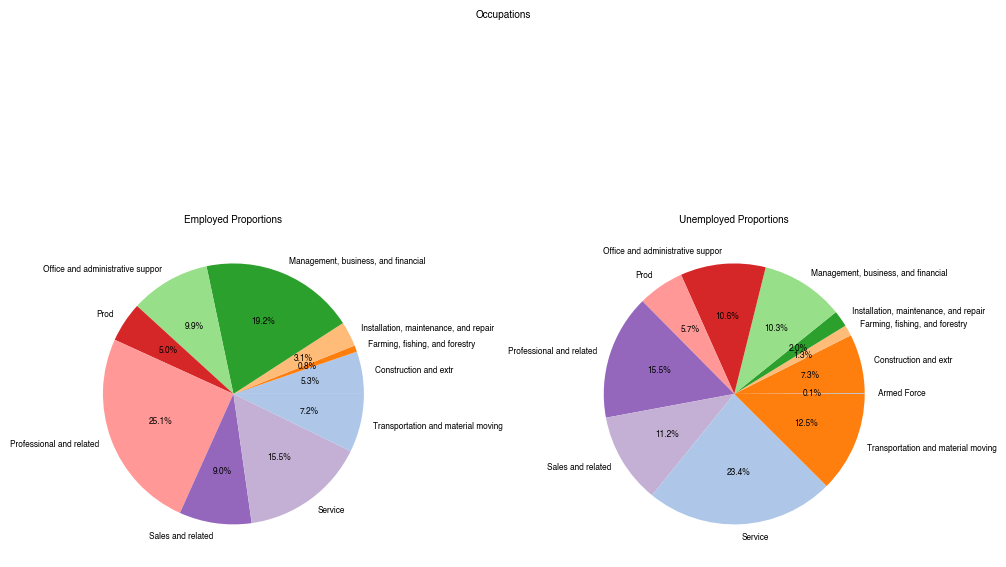

In [114]:

fig, axs = plt.subplots(1,2, figsize=(10,8))
labels1 = employed_occupation.index
labels2 = unemployed_occupation.index
colors = dict(zip(labels1, plt.cm.tab20.colors[:len(labels1)]))

axs[0].pie(employed_occupation, autopct='%1.1f%%', labels=labels1, colors=[colors[key] for key in labels1[1:]])
axs[1].pie(unemployed_occupation, autopct='%1.1f%%', labels=labels2, colors=[colors[key] for key in labels1[1:]])
plt.tight_layout()
axs[0].set_title('Employed Proportions')
axs[1].set_title('Unemployed Proportions')
plt.suptitle('Occupations')
plt.show()


chi^2: 182.8802
p: 0.0000
degrees of freedom: 10
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

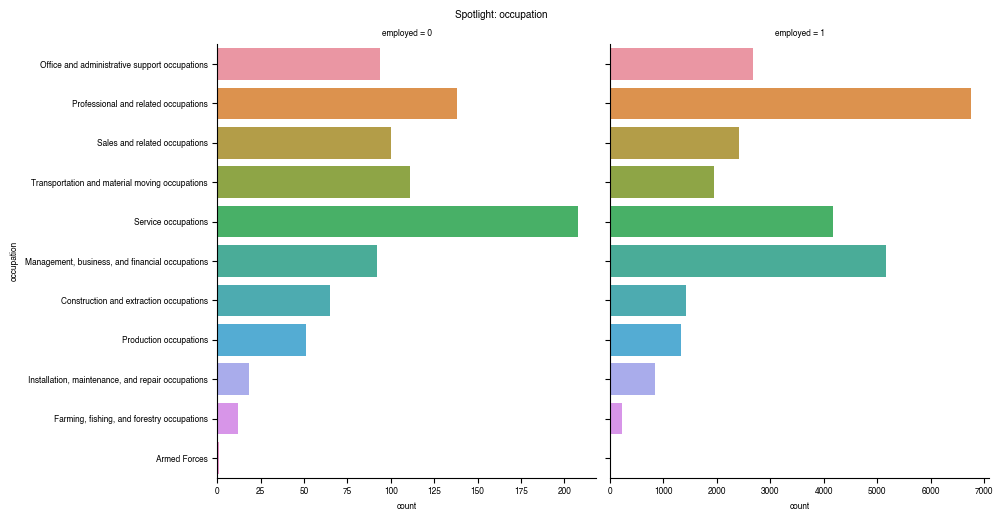

population_proportions  \
                                                                employed   
occupation                                                                 
Armed Forces                                                         NaN   
Transportation and material moving occupations                     0.072   
Farming, fishing, and forestry occupations                         0.008   
Service occupations                                                0.155   
Construction and extraction occupations                            0.053   
Sales and related occupations                                      0.090   
Production occupations                                             0.050   
Office and administrative support occupations                      0.099   
Installation, maintenance, and repair occupations                  0.031   
Professional and related occupations                               0.251   
Management, business, and financial occupations                    0.192   

                                                                     \
                                                  unemployed change   
occupation                                                            
Armed Forces                                           0.001    NaN   
Transportation and material moving occupations         0.125 -0.052   
Farming, fishing, and forestry occupations             0.013 -0.006   
Service occupations                                    0.234 -0.078   
Construction and extraction occupations                0.073 -0.021   
Sales and related occupations                          0.112 -0.023   
Production occupations                                 0.057 -0.008   
Office and administrative support occupations          0.106 -0.006   
Installation, maintenance, and repair occupations      0.020  0.011   
Professional and related occupations                   0.155  0.096   
Management, business, and financial occupations        0.103  0.088   

                                                  unemployment_rate  
                                                                     
occupation                                                           
Armed Forces                                                   1.00  
Transportation and material moving occupations                 0.05  
Farming, fishing, and forestry occupations                     0.05  
Service occupations                                            0.05  
Construction and extraction occupations                        0.04  
Sales and related occupations                                  0.04  
Production occupations                                         0.04  
Office and administrative support occupations                  0.03  
Installation, maintenance, and repair occupations              0.02  
Professional and related occupations                           0.02  
Management, business, and financial occupations                0.02

In [51]:
spotlight_stats(train, 'occupation', 'occupation', orientation='h')

#### Statistical Testing

In [52]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['occupation'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   1    0]
 [  65 1414]
 [  12  214]
 [  18  833]
 [  92 5162]
 [  94 2671]
 [  51 1336]
 [ 138 6756]
 [ 100 2412]
 [ 208 4181]
 [ 111 1949]]
---
Expected

[[   0    0]
 [  47 1431]
 [   7  218]
 [  27  823]
 [ 168 5085]
 [  88 2676]
 [  44 1342]
 [ 220 6673]
 [  80 2431]
 [ 140 4248]
 [  65 1994]]
---

chi^2: 182.8802
p: 0.0000
degrees of freedom: 10
Reject null hypothesis


### October Questions
* Effect of Age
* Median Income
* Gender Make Up
* Marital Status
* Education


In [53]:
# average age of data set
train.age.mean()

43.229635487813646

In [54]:
#### Effect of Age
# management, business, and financial with highest mean age
# service is youngest
train.groupby('occupation')['age'].mean().sort_values()

occupation
Armed Forces                                         24.000000
Service occupations                                  40.177489
Sales and related occupations                        41.909634
Construction and extraction occupations              42.039216
Installation, maintenance, and repair occupations    42.351351
Transportation and material moving occupations       42.531553
Production occupations                               42.723864
Office and administrative support occupations        43.577939
Farming, fishing, and forestry occupations           43.650442
Professional and related occupations                 43.705106
Management, business, and financial occupations      46.473354
Name: age, dtype: float64

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27818 entries, 3549 to 30192
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27818 non-null  object  
 1   household_num               27818 non-null  float64 
 2   family_income               27818 non-null  category
 3   household_type              27818 non-null  object  
 4   own_bus_or_farm             27818 non-null  int64   
 5   region                      27818 non-null  object  
 6   state                       27818 non-null  object  
 7   metropolitan                27818 non-null  object  
 8   metro_area_size             27818 non-null  float64 
 9   age                         27818 non-null  float64 
 10  marital_status              27818 non-null  object  
 11  is_male                     27818 non-null  int64   
 12  veteran                     27818 non-null  int64   
 13  education    

In [56]:
####  Family Income
# Over 30% of both professional and management occupation households make 150,000 or More
# Over 40% of farming and service occupation households make less than 50,000
# less than 10% of construction occupation households make more than 150,000
train.groupby('occupation')['family_income'].value_counts(normalize=True).unstack()


,"0 TO 49,999","50,000 to 74,999","75,000 to 99,999","100,000 to 149,999","150,000 or More"
occupation,,,,,
Armed Forces,1.000000,0.000000,0.000000,0.000000,0.000000
Construction and extraction occupations,0.362407,0.231237,0.154158,0.155510,0.096687
"Farming, fishing, and forestry occupations",0.460177,0.252212,0.101770,0.097345,0.088496
"Installation, maintenance, and repair occupations",0.247944,0.209166,0.185664,0.200940,0.156287
"Management, business, and financial occupations",0.114770,0.127141,0.144081,0.233917,0.380091
Office and administrative support occupations,0.273418,0.215913,0.163472,0.185533,0.161664
Production occupations,0.324441,0.256669,0.162942,0.158616,0.097332
Professional and related occupations,0.132869,0.155352,0.145924,0.229765,0.336089
Sales and related occupations,0.257962,0.173965,0.138933,0.187500,0.241640


In [57]:
####Gender Make Up
# production occupations sho 16% gap in proportionality with 43% of women in the occupation making less than 50k. similiar difference in sales (12%)
# in farming there is a 10% proportionality difference in the 100k to 149k range (11%) be similar numbers elsewhere
# next iteration explore absolute value of difference 
train.groupby(['occupation','is_male' ])['family_income'].value_counts(normalize=True).unstack()

0 TO 49,999  \
occupation                                        is_male                
Armed Forces                                      1           1.000000   
Construction and extraction occupations           0           0.348485   
                                                  1           0.363057   
Farming, fishing, and forestry occupations        0           0.491228   
                                                  1           0.449704   
Installation, maintenance, and repair occupations 0           0.309524   
                                                  1           0.244747   
Management, business, and financial occupations   0           0.116269   
                                                  1           0.113517   
Office and administrative support occupations     0           0.278269   
                                                  1           0.259918   
Production occupations                            0           0.437659   
                                                  1           0.279678   
Professional and related occupations              0           0.154933   
                                                  1           0.103037   
Sales and related occupations                     0           0.318542   
                                                  1           0.196800   
Service occupations                               0           0.423930   
                                                  1           0.374506   
Transportation and material moving occupations    0           0.423158   
                                                  1           0.342587   

                                                           50,000 to 74,999  \
occupation                                        is_male                     
Armed Forces                                      1                0.000000   
Construction and extraction occupations           0                0.272727   
                                                  1                0.229299   
Farming, fishing, and forestry occupations        0                0.245614   
                                                  1                0.254438   
Installation, maintenance, and repair occupations 0                0.190476   
                                                  1                0.210136   
Management, business, and financial occupations   0                0.133835   
                                                  1                0.121551   
Office and administrative support occupations     0                0.210914   
                                                  1                0.229822   
Production occupations                            0                0.239186   
                                                  1                0.263581   
Professional and related occupations              0                0.161746   
                                                  1                0.146708   
Sales and related occupations                     0                0.186212   
                                                  1                0.161600   
Service occupations                               0                0.202217   
                                                  1                0.209250   
Transportation and material moving occupations    0                0.231579   
                                                  1                0.223344   

                                                           75,000 to 99,999  \
occupation                                        is_male                     
Armed Forces                                      1                0.000000   
Construction and extraction occupations           0                0.196970   
                                                  1                0.152159   
Farming, fishing, and forestry occupations        0                0.140351   
                                                  1             

In [58]:
# Education
# ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
# construction, farming, service occupations all hve greter than 15% with no high school


In [59]:
train.groupby(['occupation' ])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
occupation,,,,,
Armed Forces,0.000000,1.000000,0.000000,0.000000,0.000000
Construction and extraction occupations,0.186613,0.611224,0.111562,0.074375,0.016227
"Farming, fishing, and forestry occupations",0.252212,0.557522,0.070796,0.092920,0.026549
"Installation, maintenance, and repair occupations",0.069330,0.623972,0.197415,0.092832,0.016451
"Management, business, and financial occupations",0.020175,0.275219,0.085459,0.394557,0.224591
Office and administrative support occupations,0.033996,0.532731,0.141772,0.233996,0.057505
Production occupations,0.118241,0.651045,0.116078,0.087239,0.027397
Professional and related occupations,0.009428,0.153902,0.099652,0.361474,0.375544
Sales and related occupations,0.079618,0.494427,0.101513,0.263535,0.060908


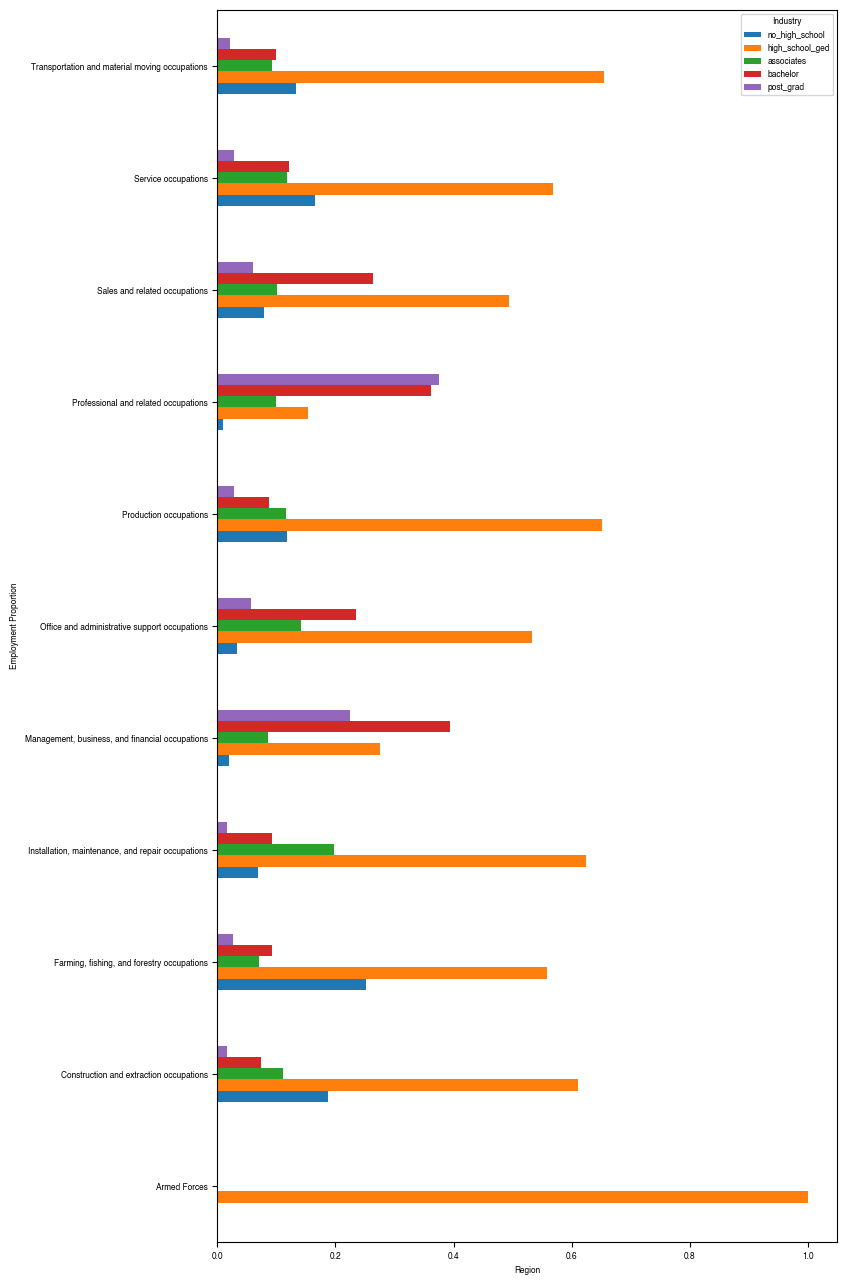

In [60]:

df_bar = train.groupby(['occupation' ])['education'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(figsize=(8,16))
df_bar.plot(kind='barh', ax=ax)
plt.legend(title='Industry')
plt.ylabel('Employment Proportion')
plt.xlabel('Region')
plt.show()

---
### Takeways
* Farming fishing and forestry at the top
* service occupations, transportation and material movie tied for 2nd
* service occupations highest change in proportionality
* management, business, and financial with highest mean age
* service is youngest
* Over 30% of both professional and management occupation households make 150,000 or More
* Over 40% of farming and service occupation households make less than 50,000
* less than 10% of construction occupation households make more than 150,000
* ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
* construction, farming, service occupations all have greter than 15% with no high school
---

## Spotlight - Marital Status


* **Question:** Which marital status disposition shows the largest population proportion change between employed and unemployed?  
* **Answer:** Single individuals make up a larger share of the unemployed and have an unemployment rate of 5%.

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `marital_status` and `employment` status   
>* ${H_a}$: There is a relationship between `marital_status` and `employment` status  
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 163.8726
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

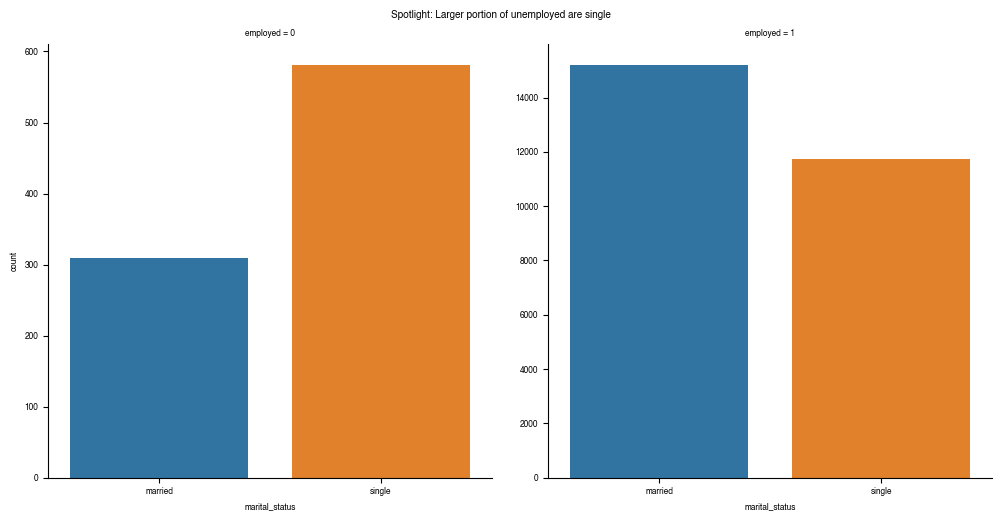

population_proportions                   unemployment_rate
                             employed unemployed change                  
marital_status                                                           
single                          0.436      0.653 -0.217              0.05
married                         0.564      0.347  0.217              0.02

In [61]:
spotlight_stats(train, 'marital_status', 'Larger portion of unemployed are single')

#### Statistical Testing

In [62]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['marital_status'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  309 15198]
 [  581 11730]]
---
Expected

[[  496 15010]
 [  393 11917]]
---

chi^2: 163.8726
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


### October Questions 
* Effect on Income
* Relationship with professional certification

In [63]:
train.marital_status.value_counts()

married    15507
single     12311
Name: marital_status, dtype: int64

In [64]:
married = train[train.marital_status == 'married']

In [65]:
single = train[train.marital_status != 'married']

In [66]:
married.family_income.value_counts(normalize=True)

150,000 or More       0.305410
100,000 to 149,999    0.225253
0 TO 49,999           0.161153
50,000 to 74,999      0.160508
75,000 to 99,999      0.147675
Name: family_income, dtype: float64

In [67]:
single.family_income.value_counts(normalize=True)

0 TO 49,999           0.344651
50,000 to 74,999      0.209650
100,000 to 149,999    0.152709
150,000 or More       0.150841
75,000 to 99,999      0.142149
Name: family_income, dtype: float64

In [68]:
train[train.professional_certification == 1].age.mean()

45.48690946321486

In [69]:
married.age.mean()

47.49538917908041

In [70]:
single.age.mean()

37.85646982373487

In [71]:
train.groupby('marital_status')['professional_certification'].mean()

marital_status
married    0.285291
single     0.196004
Name: professional_certification, dtype: float64

---
### Takeaways
* `single` individuals with highest unemployment rate, 5% vs 2%
* `married` make up larger portion of data 
* proportinality difference is more than a simple doubling of income.
    * 34% of single make less than 50k but over 50% of married have household income more than 100k
* 28% of married have professional certification, 19% of single individuals
    * Can possibly be explained by average single person being 8 years younger than the average age of those with professional certifications
* Next Steps
    * should examine age by bins later
---

## Spotlight - Race


* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Indivduals identifying as White show the largest population proportion change with a drop of nearly 10% when comparing employed vs unemployed. Those identifying as mixed race other than white, and Indigenous have the highest unemployed rates at 8% and 7% respectively. 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `race` and `employment` status   
>* ${H_a}$: There is a relationship between `race` and `employment` status   
* ${\alpha}$: .05  
* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 102.8163
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

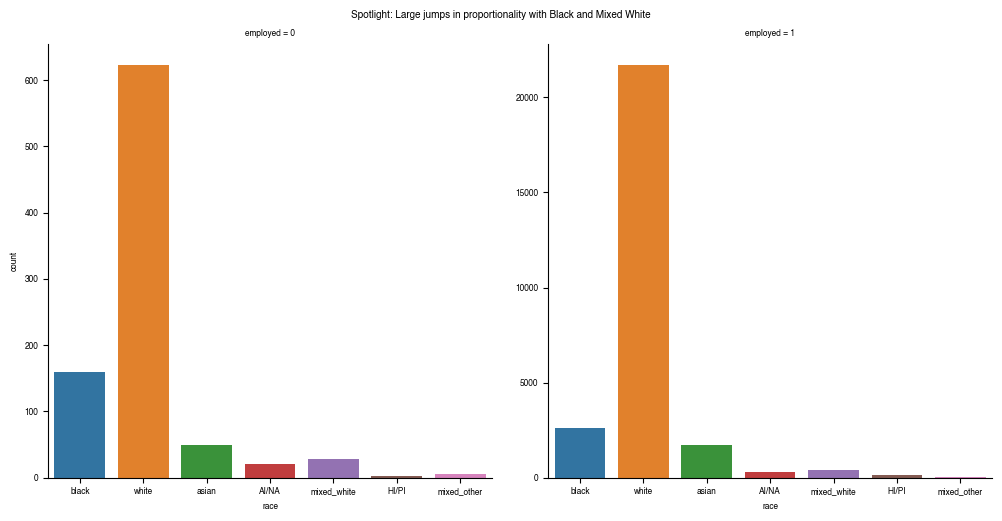

population_proportions                   unemployment_rate
                          employed unemployed change                  
race                                                                  
mixed_other                  0.002      0.006 -0.003              0.08
AI/NA                        0.010      0.024 -0.013              0.07
mixed_white                  0.016      0.033 -0.017              0.06
black                        0.098      0.179 -0.081              0.06
asian                        0.063      0.056  0.007              0.03
white                        0.806      0.700  0.106              0.03
HI/PI                        0.005      0.003  0.001              0.02

In [72]:
spotlight_stats(train, 'race', 'Large jumps in proportionality with Black and Mixed White')

#### Statistical Testing

In [73]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['race'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   21   275]
 [    3   130]
 [   50  1699]
 [  159  2636]
 [    5    61]
 [   29   422]
 [  623 21705]]
---
Expected

[[    9   286]
 [    4   128]
 [   55  1693]
 [   89  2705]
 [    2    63]
 [   14   436]
 [  714 21613]]
---

chi^2: 102.8163
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


### October Questions
* Income
* Education
* Region
* Full or Part Time 

In [74]:
train.groupby(['race'])['family_income'].value_counts(normalize=True).unstack()

,"0 TO 49,999","50,000 to 74,999","75,000 to 99,999","100,000 to 149,999","150,000 or More"
race,,,,,
AI/NA,0.439189,0.182432,0.118243,0.165541,0.094595
HI/PI,0.263158,0.210526,0.150376,0.210526,0.165414
asian,0.174957,0.133791,0.121212,0.181246,0.388794
black,0.376029,0.205367,0.139535,0.129159,0.149911
mixed_other,0.303030,0.257576,0.106061,0.166667,0.166667
mixed_white,0.294900,0.177384,0.192905,0.166297,0.168514
white,0.226935,0.182865,0.147304,0.202974,0.239923


In [75]:
train.groupby(['race'])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
race,,,,,
AI/NA,0.125000,0.530405,0.141892,0.131757,0.070946
HI/PI,0.075188,0.541353,0.105263,0.187970,0.090226
asian,0.041738,0.253288,0.063465,0.342481,0.299028
black,0.069767,0.498748,0.120572,0.191413,0.119499
mixed_other,0.030303,0.545455,0.090909,0.242424,0.090909
mixed_white,0.108647,0.465632,0.135255,0.188470,0.101996
white,0.074122,0.412979,0.108787,0.252553,0.151559


In [76]:
train.groupby(['region'])['race'].value_counts(normalize=True).unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
region,,,,,,,
EAST NORTH CENTRAL,0.003792,0.002068,0.043089,0.091348,0.000345,0.012754,0.846605
EAST SOUTH CENTRAL,0.003859,0.001654,0.014884,0.201764,0.001103,0.008820,0.767916
MIDDLE ATLANTIC,0.003015,0.002153,0.105943,0.118002,0.003015,0.008613,0.759259
MOUNTAIN,0.024065,0.006669,0.032473,0.022905,0.002030,0.018846,0.893012
NEW ENGLAND,0.003620,0.000905,0.043439,0.056109,NaN,0.012217,0.883710
PACIFIC,0.018768,0.018527,0.167709,0.039220,0.008181,0.031761,0.715833
SOUTH ATLANTIC,0.004684,0.001952,0.048009,0.189305,0.001952,0.013466,0.740632
WEST NORTH CENTRAL,0.009468,0.001092,0.025127,0.040422,NaN,0.015295,0.908594
WEST SOUTH CENTRAL,0.016796,0.001292,0.042313,0.143088,0.001615,0.013889,0.781008


In [77]:
train.groupby(['race'])['ft_or_pt'].value_counts(normalize=True).unstack()

ft_or_pt,full_time,part_time
race,,
AI/NA,0.834459,0.165541
HI/PI,0.879699,0.120301
asian,0.858205,0.141795
black,0.853667,0.146333
mixed_other,0.757576,0.242424
mixed_white,0.767184,0.232816
white,0.825869,0.174131


In [78]:
train.ft_or_pt.value_counts(normalize=True)

full_time    0.82993
part_time    0.17007
Name: ft_or_pt, dtype: float64

---
### Takeways
* Mixed raced top of unemployed
* indeginous, black, and hi/pi among tops in unemployment
* black with highest change in proportionality 
* Income
    * Indigenous with populations with highest proportion under 50k --> 44%
    * Asian with highest proportion above 150k --> 38%
* Education
    * Majority Asian have bachelor's or greater, only racial group that holds true for
* Region 
    * Not much interesting to take away. Most regions above 75% White with lowest proportions in South Atlantic and Pacific
    * The losses there primarily come from gains to Black (south atlantic) and Asian (pacific)
    * Pacfic with largest proportion of mixed race individuals
* Full or Part Time 
    * only mixed race show positive deviations in proportion
---

## Spotlight - Professional Certification

* **Question:** What is the effect of having a professional certification?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 92.0426
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

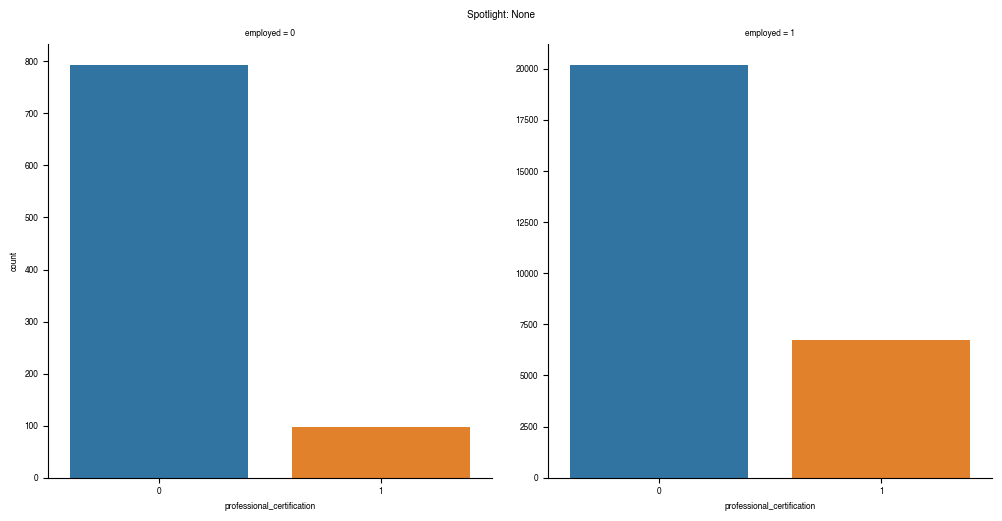

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                            0.75      0.891 -0.141   
1                                            0.25      0.109  0.141   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.01

In [79]:
spotlight_stats(train, 'professional_certification')

#### Statistical Testing

In [80]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['professional_certification'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  793 20188]
 [   97  6740]]
---
Expected

[[  671 20309]
 [  218  6618]]
---

chi^2: 92.0426
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


### October Questions
* Effect of Education
* Race 
* Occupation


In [81]:
train.groupby(['professional_certification'])['education'].value_counts(normalize=True).unstack()

,no_high_school,high_school_ged,associates,bachelor,post_grad
professional_certification,,,,,
0,0.089700,0.463658,0.094514,0.243554,0.108574
1,0.020331,0.264005,0.148749,0.267369,0.299547


In [82]:
train.groupby(['professional_certification'])['race'].value_counts(normalize=True).unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
professional_certification,,,,,,,
0,0.011296,0.005291,0.066441,0.104047,0.002383,0.016682,0.793861
1,0.008630,0.003218,0.051923,0.089513,0.002340,0.014773,0.829604


In [83]:
train.groupby(['professional_certification'])['occupation'].value_counts(normalize=True).unstack()

occupation,Armed Forces,Construction and extraction occupations,"Farming, fishing, and forestry occupations","Installation, maintenance, and repair occupations","Management, business, and financial occupations",Office and administrative support occupations,Production occupations,Professional and related occupations,Sales and related occupations,Service occupations,Transportation and material moving occupations
professional_certification,,,,,,,,,,,
0,0.000048,0.056718,0.009723,0.031028,0.196940,0.118298,0.060102,0.183261,0.098470,0.165912,0.079501
1,NaN,0.042270,0.003218,0.029253,0.164107,0.041392,0.018429,0.445956,0.065233,0.132807,0.057335


---
#### Takeways
* 4x the unemployment rate for those without a professional_certification
* Effect of Education
    * those with professsional certification more likely to have completed bachelor's and above. largest gains in post_grad area. 19% greater proportionality. Much less likely to have no high school diploma/ged 
* Race
    * consistent proportions across all racial groups 
* Occupation
    * office/admin support show lower proportions 
    * professional occupations show much greater proportionality. 44% of those employed with professional certification work in those occupations
---


In [84]:
reload(model)

<module 'model' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/model.py'>

In [85]:
#explore.spotlight_stats(train, 'professional_certification', 'Professional Certification Status')

## Spotlight Unexplored Features

### Household Number
* Create Box plot that shows mean household number 
* Look at mean # in household
* Takeaways
    * Almost even number for both employed and unemployed. around 3 per household
    * Climbs in unemployement rate as families grow larger
    * above seven they make up a small portion of data


<AxesSubplot:xlabel='employed', ylabel='household_num'>

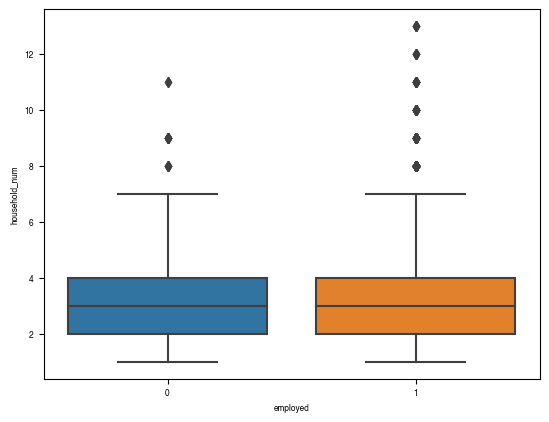

In [86]:
sns.boxplot(data=train, x='employed', y='household_num')

In [87]:
train.groupby('employed')['household_num'].mean()

employed
0    3.177528
1    3.017194
Name: household_num, dtype: float64

<AxesSubplot:xlabel='household_num'>

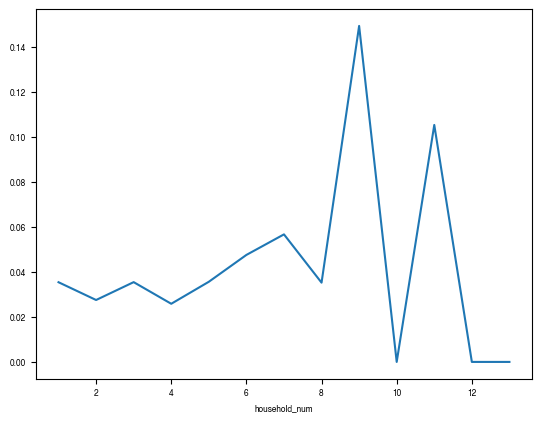

In [88]:
(1-train.groupby('household_num')['employed'].mean()).plot(kind='line')

In [89]:
train.household_num.value_counts()

2.0     9053
3.0     5530
4.0     5459
1.0     3531
5.0     2556
6.0     1073
7.0      353
8.0      142
9.0       67
10.0      25
11.0      19
12.0       5
13.0       5
Name: household_num, dtype: int64

### State


### Metropolitan and Metro Area Size


### Age
* Create Box plot that shows mean age
* Use descriptive statistics on unemployed and employed dataframes
* Takeaways 
    * Employed older by 5 years, and a bit more tightly packed.
    * Neither with outliers which can be thought of as accounting for retirement age. 


In [90]:
train.groupby('employed')['age'].mean()

employed
0    38.048315
1    43.400884
Name: age, dtype: float64

<AxesSubplot:xlabel='employed', ylabel='age'>

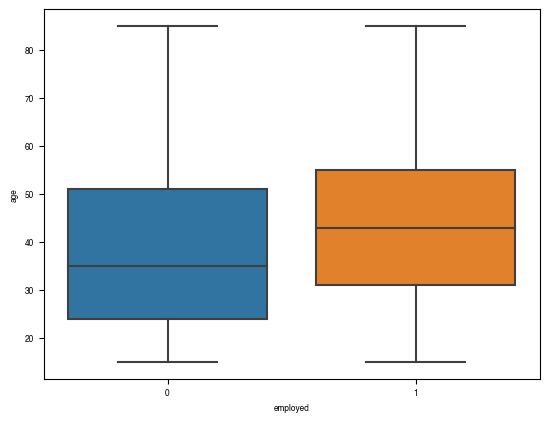

In [91]:
sns.boxplot(data=train, x='employed', y='age')

### Veteran
* Takeaways
    * Lower unemployement rate for veterans
    * Holds true between service eras. Half a percentage point difference


In [92]:
1-train.groupby('veteran')['employed'].mean()

veteran
0    0.032123
1    0.029477
Name: employed, dtype: float64

In [93]:
1-train.groupby(by=['service_era', 'veteran'])['employed'].mean()

service_era  veteran
n/a          0          0.032123
post_gwot    1          0.032967
pre_gwot     1          0.027716
Name: employed, dtype: float64

### Hispanic or non
* Want to find some way to blend this into racial category
* Takeaways
    * Non-Hispanic White have 2.6 unemployement vs 3.5 for Hispanic White (91% of Hispanic)
    * This is the primary driver of their climb in unemployement rate
    * Hispanic Black have 4.4% unemployment, but this is lower than Non-Hispanic Black

In [94]:
1-train[train.hispanic_or_non ==1].employed.mean()

0.036951501154734445

In [95]:
train[train.hispanic_or_non ==1].race.value_counts(normalize=True)

white          0.912702
black          0.041801
mixed_white    0.019400
AI/NA          0.013857
asian          0.007390
HI/PI          0.003233
mixed_other    0.001617
Name: race, dtype: float64

In [96]:
1-train.groupby(['hispanic_or_non', 'race']).employed.mean().unstack()

race,AI/NA,HI/PI,asian,black,mixed_other,mixed_white,white
hispanic_or_non,,,,,,,
0,0.067797,0.02521,0.027956,0.057766,0.084746,0.070845,0.026175
1,0.083333,0.00000,0.062500,0.044199,0.000000,0.035714,0.035931


---
### Immmigration
* Goals:
    * Explore Immigration features.
    * Create loop for dataframes exploring unemployement rate
* Takeaways:
    * Employement rates stay essentially level
    * Statistical testing suggests that the difference found with parent's birth country may be an anomaly
    * The lack of difference means it is possible to go ahead and remove immigration categories from model in order to reduce noise. Will leave in dframe for future iterations of project that will explore variances in regionality


In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27818 entries, 3549 to 30192
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27818 non-null  object  
 1   household_num               27818 non-null  float64 
 2   family_income               27818 non-null  category
 3   household_type              27818 non-null  object  
 4   own_bus_or_farm             27818 non-null  int64   
 5   region                      27818 non-null  object  
 6   state                       27818 non-null  object  
 7   metropolitan                27818 non-null  object  
 8   metro_area_size             27818 non-null  float64 
 9   age                         27818 non-null  float64 
 10  marital_status              27818 non-null  object  
 11  is_male                     27818 non-null  int64   
 12  veteran                     27818 non-null  int64   
 13  education    


---
Mini Spotlight: birth_country propotions
us_50              0.827054
foreign_country    0.168164
us_territories     0.004781
Name: birth_country, dtype: float64
---
chi^2: 0.1378
p: 0.9334
degrees of freedom: 2
Fail to reject null hypothesis


<Figure size 2000x600 with 0 Axes>

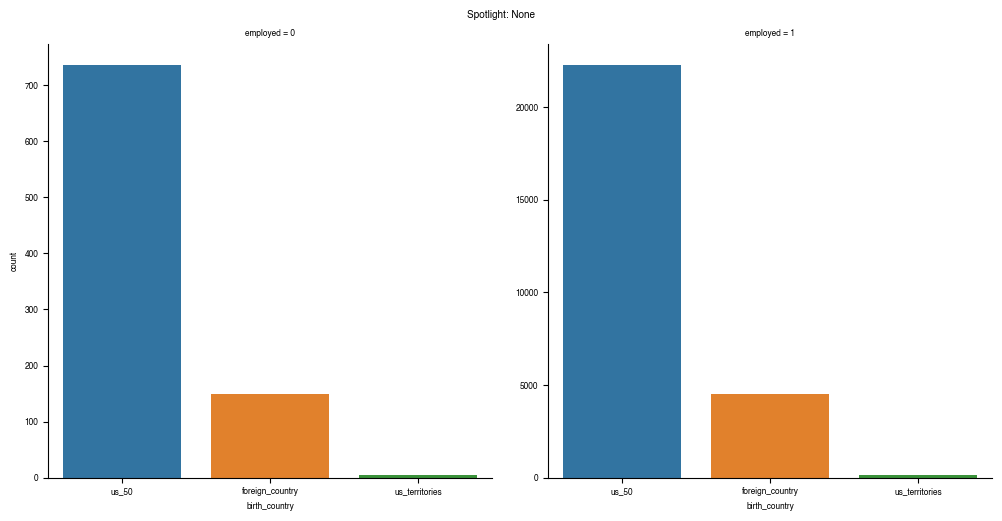

                population_proportions                   unemployment_rate
                              employed unemployed change                  
birth_country                                                             
us_territories                   0.005      0.006 -0.001              0.04
us_50                            0.827      0.827  0.000              0.03
foreign_country                  0.168      0.167  0.001              0.03

---
Mini Spotlight: mother_birth_country propotions
us_50              0.765152
foreign_country    0.227766
us_territories     0.007082
Name: mother_birth_country, dtype: float64
---
chi^2: 3.0912
p: 0.2132
degrees of freedom: 2
Fail to reject null hypothesis


<Figure size 2000x600 with 0 Axes>

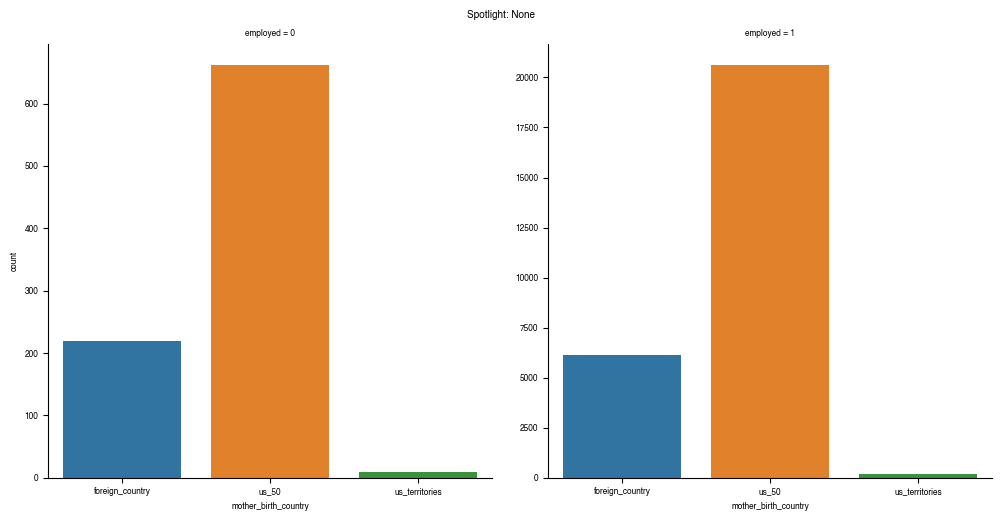

                     population_proportions                    \
                                   employed unemployed change   
mother_birth_country                                            
us_territories                        0.007      0.010 -0.003   
foreign_country                       0.227      0.246 -0.019   
us_50                                 0.766      0.744  0.022   

                     unemployment_rate  
                                        
mother_birth_country                    
us_territories                    0.05  
foreign_country                   0.03  
us_50                             0.03  

---
Mini Spotlight: father_birth_country propotions
us_50              0.765116
foreign_country    0.227407
us_territories     0.007477
Name: father_birth_country, dtype: float64
---
chi^2: 3.0392
p: 0.2188
degrees of freedom: 2
Fail to reject null hypothesis


<Figure size 2000x600 with 0 Axes>

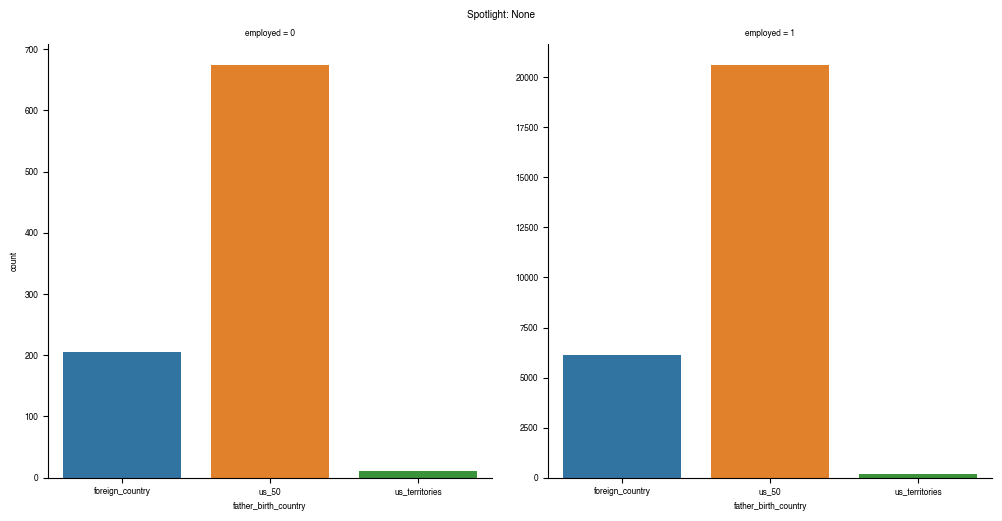

                     population_proportions                    \
                                   employed unemployed change   
father_birth_country                                            
us_territories                        0.007      0.012 -0.005   
foreign_country                       0.227      0.230 -0.003   
us_50                                 0.765      0.757  0.008   

                     unemployment_rate  
                                        
father_birth_country                    
us_territories                    0.05  
foreign_country                   0.03  
us_50                             0.03  

---
Mini Spotlight: citizenship propotions
native         0.841541
foreign        0.079553
naturalized    0.078906
Name: citizenship, dtype: float64
---
chi^2: 1.4515
p: 0.4840
degrees of freedom: 2
Fail to reject null hypothesis


<Figure size 2000x600 with 0 Axes>

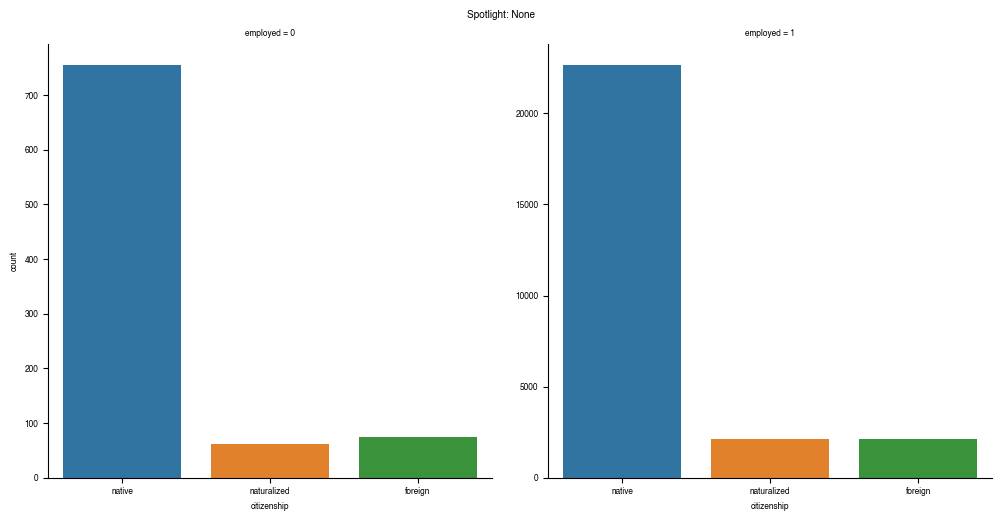

            population_proportions                   unemployment_rate
                          employed unemployed change                  
citizenship                                                           
foreign                      0.079      0.083 -0.004              0.03
native                       0.841      0.848 -0.007              0.03
naturalized                  0.079      0.069  0.011              0.03

---
Mini Spotlight: immigration_era propotions
native       0.827234
post_pwot    0.098965
pre_gwot     0.073801
Name: immigration_era, dtype: float64
---
chi^2: 1.4911
p: 0.4745
degrees of freedom: 2
Fail to reject null hypothesis


<Figure size 2000x600 with 0 Axes>

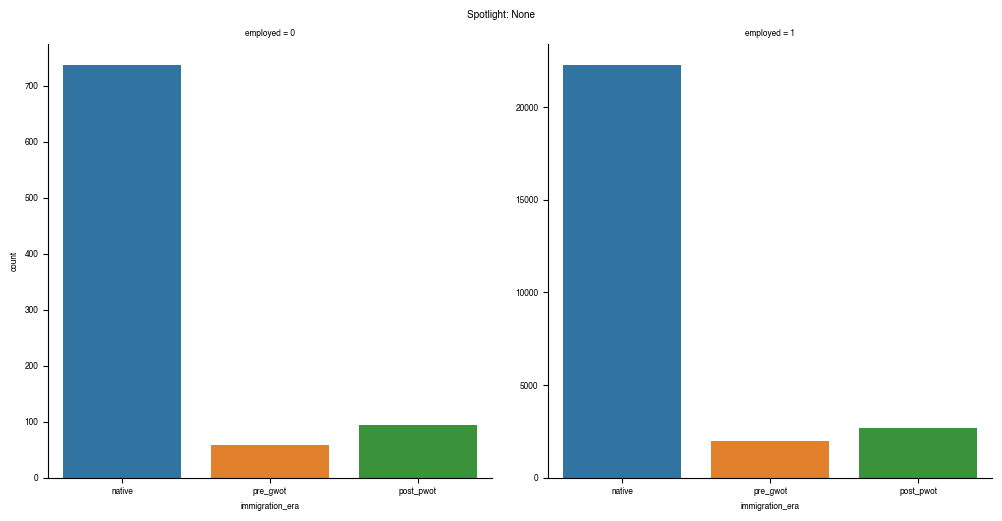

                population_proportions                   unemployment_rate
                              employed unemployed change                  
immigration_era                                                           
post_pwot                        0.099      0.107 -0.008              0.03
native                           0.827      0.828 -0.001              0.03
pre_gwot                         0.074      0.065  0.009              0.03


In [98]:
#create columns to sort through
immigration_cols = ['birth_country','mother_birth_country','father_birth_country','citizenship', 'immigration_era']
#begin for loop
for col in immigration_cols:
    print('\n---')
    #call spotlight function on each column
    print(f'Mini Spotlight: {col} propotions')
    print(train[col].value_counts(normalize=True))
    print('---')
    print(spotlight_stats(train, col))



---
### Full Time or Part Time

* Goals:
    * exlore regionality, industry, and occupationl differences in part time vs full time work
    * take a look at spotlight stats
* Takeaways:
    * slightly higher unemployement rate, but not dramatically so. 1%. statistically verified
    * East North Central shows 2% gain in unemplouyement rate part time vs full time
    * West North Central showing under 3% employement rate. Will be worth looking at that mixed with industry/occupation
    * Construction, financial activities, information, manufacturing, and public administration show large (2%+)jumps between full time and part time unemployment rates
    * Lesiure and hospitality show a drop, with full time workers in that industry having unemployment of 7.2%


chi^2: 4.0303
p: 0.0447
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

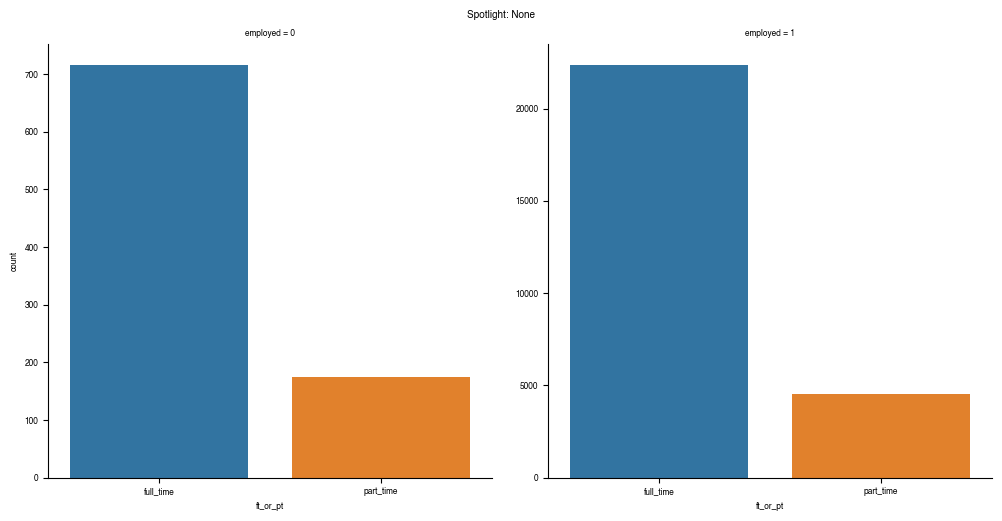

population_proportions                   unemployment_rate
                        employed unemployed change                  
ft_or_pt                                                            
part_time                  0.169      0.196 -0.026              0.04
full_time                  0.831      0.804  0.026              0.03

In [99]:
spotlight_stats(train, 'ft_or_pt')

In [100]:
train.groupby(['region','ft_or_pt']).employed.value_counts(normalize=True).unstack()

employed                             0         1
region             ft_or_pt                     
EAST NORTH CENTRAL full_time  0.030603  0.969397
                   part_time  0.051635  0.948365
EAST SOUTH CENTRAL full_time  0.030908  0.969092
                   part_time  0.042146  0.957854
MIDDLE ATLANTIC    full_time  0.031476  0.968524
                   part_time  0.031250  0.968750
MOUNTAIN           full_time  0.032822  0.967178
                   part_time  0.029412  0.970588
NEW ENGLAND        full_time  0.032077  0.967923
                   part_time  0.039261  0.960739
PACIFIC            full_time  0.036842  0.963158
                   part_time  0.035326  0.964674
SOUTH ATLANTIC     full_time  0.030892  0.969108
                   part_time  0.035809  0.964191
WEST NORTH CENTRAL full_time  0.019273  0.980727
                   part_time  0.028078  0.971922
WEST SOUTH CENTRAL full_time  0.031262  0.968738
                   part_time  0.040169  0.959831

In [101]:
train.groupby(['industry','ft_or_pt']).employed.value_counts(normalize=True).unstack()

employed                                                      0         1
industry                                    ft_or_pt                     
Agriculture, forestry, fishing, and hunting full_time  0.028761  0.971239
                                            part_time  0.020619  0.979381
Armed Forces                                full_time  1.000000       NaN
Construction                                full_time  0.035752  0.964248
                                            part_time  0.056497  0.943503
Educational and health services             full_time  0.022553  0.977447
                                            part_time  0.030278  0.969722
Financial activities                        full_time  0.020719  0.979281
                                            part_time  0.041026  0.958974
Information                                 full_time  0.034247  0.965753
                                            part_time  0.064516  0.935484
Leisure and hospitality                     full_time  0.072090  0.927910
                                            part_time  0.043290  0.956710
Manufacturing                               full_time  0.027709  0.972291
                                            part_time  0.054422  0.945578
Mining                                      full_time  0.023256  0.976744
                                            part_time       NaN  1.000000
Other services                              full_time  0.023127  0.976873
                                            part_time  0.026627  0.973373
Professional and business services          full_time  0.031933  0.968067
                                            part_time  0.029106  0.970894
Public administration                       full_time  0.012593  0.987407
                                            part_time  0.064935  0.935065
Transportation and utilities                full_time  0.035111  0.964889
                                            part_time  0.025510  0.974490
Wholesale and retail trade                  full_time  0.039074  0.960926
                                            part_time  0.039555  0.960445

---
### num of children
    * Goals:
        * Basic understanding of relationship, and does rate differ with number of children
    * Takeaways
        * May be worth flattening to 4+ children and making categorical
        * seems to be a drop in rate until 3 children, and then it jumps dramatically

In [102]:
train.num_children.value_counts(normalize=True)

0.0    0.690848
1.0    0.131246
2.0    0.117550
3.0    0.044288
4.0    0.012762
5.0    0.001833
6.0    0.000971
7.0    0.000324
8.0    0.000180
Name: num_children, dtype: float64

<AxesSubplot:xlabel='num_children'>

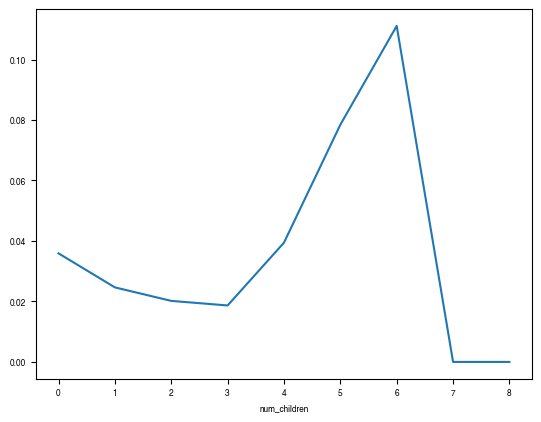

In [103]:
(1-train.groupby('num_children')['employed'].mean()).plot(kind='line')

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27818 entries, 3549 to 30192
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   housing_type                27818 non-null  object  
 1   household_num               27818 non-null  float64 
 2   family_income               27818 non-null  category
 3   household_type              27818 non-null  object  
 4   own_bus_or_farm             27818 non-null  int64   
 5   region                      27818 non-null  object  
 6   state                       27818 non-null  object  
 7   metropolitan                27818 non-null  object  
 8   metro_area_size             27818 non-null  float64 
 9   age                         27818 non-null  float64 
 10  marital_status              27818 non-null  object  
 11  is_male                     27818 non-null  int64   
 12  veteran                     27818 non-null  int64   
 13  education    

# Exploration Summary
## Key Takeways
* Industry
    * `Leisure and hospitality` with highest industry unemployment rate, highest jump in proportionality
    * Regionality played large factor in unemployment rate variance within various industries
    * information with highest unemployement rate (5.7%) in Pacific where it makes up highest percetange of workforce nationwide (2.5%). `blacks` with triple unemployment rate in professional and business services
* Occupation
   * `service` occupations highest change in proportionality
   * ONLY management, and profession occupations have less that 49% with only high school /ged level education. the same with more 10% post_grad
    * construction, farming, service occupations all have greter than 15% with no high school
* Marital Status
    * `single` individuals with highest unemployment rate, 5% vs 2%, highest jump in proportionality
    * proportinality difference is more than a simple doubling of income.
    * 34% of single make less than 50k but over 50% of married have household income more than 100k
    * 28% of married have professional certification, 19% of single individuals. Can possibly be explained by average single person being 8 years younger than the average age of those with professional certifications
    * professional occupations show much greater proportionality. 44% of those employed with professional certification work in those occupations. 2nd highest is management, business, and financial occupations
* Race
    * `mixed_raced_other` top of unemployed
    * `indeginous`, `black`, and `hi/pi` among tops in unemployment rate
* Professional Certification and Education
    * 4x the unemployment rate for those without a professional_certification vs those with
    * those with professsional certification more likely to have completed bachelor's and above. largest gains in post_grad area. 19% greater proportionality. Much less likely to have no high school diploma/ged 
* General
    * Climbs in unemployement rate as families grow larger
    * Employed older by 5 years, and a bit more tightly packed.
    * Non-Hispanic White have 2.6 unemployement vs 3.5 for Hispanic White (91% of Hispanic)
    * Hispanic Black have 4.4% unemployment, but this is lower than Non-Hispanic Black

------------
## Overall Summary
* Overall the conventional wisdom surrounding job prospects held true. 
* It benefits an indvidual to acquire advanced dregrees and certifications
* Having a job or career in an industry that leans more towards being a profession helps
* No major differences in takeaways from October data, but did make additional discoveries

------------
